## Retrieve the DNA sequeces from Ensembl using REST API
#### Upregulated genes by IFN (Positive Contorl)
#### Not regulated genes by IFN (Negative control)

#### Parse the positive control file and extract the gene_id, gene_name
#### Generate FASTA file

In [11]:
import pandas as pd

input_file = "../Inputs/human_IFN_up-regulation.csv"
input_df = pd.read_csv(input_file)

In [12]:
input_df

,Species,ENSEMBL ID,Gene,Expression,Orthologous Cluster ID
0,Homo sapiens,ENSG00000157601,MX1,up_regulated,HS6198
1,Homo sapiens,ENSG00000135114,OASL,up_regulated,HS1036
2,Homo sapiens,ENSG00000162654,GBP4,up_regulated,HS2530
3,Homo sapiens,ENSG00000134326,CMPK2,up_regulated,HS10449
4,Homo sapiens,ENSG00000137959,IFI44L,up_regulated,HS5101
...,...,...,...,...,...
95,Homo sapiens,ENSG00000146411,SLC2A12,up_regulated,HS14611
96,Homo sapiens,ENSG00000196517,SLC6A9,up_regulated,HS2885
97,Homo sapiens,ENSG00000139832,RAB20,up_regulated,HS6202
98,Homo sapiens,ENSG00000169255,B3GALNT1,up_regulated,HS2169


In [13]:
mode_df = input_df[['Species', 'Gene', 'ENSEMBL ID']]

In [14]:
mode_df = mode_df.rename(columns={
    'Species': 'species',
    'Gene': 'gene_name',
    'ENSEMBL ID': 'ensembl_id'
})

In [15]:
mode_df.rename(columns={
    'Species': 'species',
    'Gene': 'gene_name',
    'ENSEMBL ID': 'ensembl_id'
}, inplace=True)

In [16]:
mode_df

,species,gene_name,ensembl_id
0,Homo sapiens,MX1,ENSG00000157601
1,Homo sapiens,OASL,ENSG00000135114
2,Homo sapiens,GBP4,ENSG00000162654
3,Homo sapiens,CMPK2,ENSG00000134326
4,Homo sapiens,IFI44L,ENSG00000137959
...,...,...,...
95,Homo sapiens,SLC2A12,ENSG00000146411
96,Homo sapiens,SLC6A9,ENSG00000196517
97,Homo sapiens,RAB20,ENSG00000139832
98,Homo sapiens,B3GALNT1,ENSG00000169255


In [17]:
# Save the modified DataFrame to a new CSV file
mode_df.to_csv("../Inputs/human_IFN_up-regulation_input_example.csv", index=False)

In [18]:
# Extracting gene IDs from the DataFrame
gene_ids = input_df['ENSEMBL ID'].to_list()

In [19]:
# Extracting unique species from the DataFrame
species = list(input_df['Species'].unique())

In [20]:
for index, row in input_df.iterrows():
    
    gene_id = row['ENSEMBL ID']
    cds = fetch_cds(gene_id)
    if cds is None:
        input_df.at[index, 'cds'] = np.nan
    else:
        input_df.at[index, 'cds'] = cds
    

NameError: name 'fetch_cds' is not defined

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

positive_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_IFN_up-regulation.csv"

with open(positive_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("positive_control_sequence.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}") # need to change gene_name to gene_id for further analysis Ensembl IDs are unique but gene_names are not unique. Same gene can be presented multiple species.
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.


#### Scan IRF3 motif - exact match (Positive)

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import re
import csv

# Set the motif pattern
motif_sequence = "GAAACCGAAA"
forward_pattern = re.compile(r"GAAACCGAAA")
reverse_pattern = re.compile(r'TTTCGGTTTC')

# Empty list to store the match results
results = []

# Parse the promoter_sequences fasta file
# Extract the gene information, sequence then store at variable
for record in SeqIO.parse("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/Gene_Sequences/positive_control_sequence.fasta", "fasta"):
    gene_info = record.id
    sequence = str(record.seq)

    # Split the gene info into gene_name and gene_id
    if "_" in gene_info:
        gene_name, gene_id = gene_info.split("_", 1)
    else:
        gene_name, gene_id = gene_info, "NA"

    # Find the matches in forward strand
    forward_match = list(forward_pattern.finditer(sequence)) # make a list to count the match numbers
    forward_position = [] # prepare the empty list to add match positions
    for match in forward_match:
        start = match.start()
        end = match.end()
        forward_position.append(f'+[{start}-{end}]')
        results.append([gene_name, gene_id, '+', start, end])

    # Find the matches in reverse strand
    reverse_match = list(reverse_pattern.finditer(sequence)) # make a list to count the match numbers
    reverse_position = [] # prepare the empty list to add match positions
    for match in reverse_match:
        start = match.start()
        end = match.end()
        reverse_position.append(f'-[{start}-{end}]')
        results.append([gene_name, gene_id, '-', start, end])

    # Count total hits
    #total_hits = len(forward_match) + len(reverse_match)
    #all_positions = forward_position + reverse_position
    #all_positions = " | ".join(all_positions)

    # Add colum data into results list
    #if total_hits > 0:
    #    results.append([
    #        gene_name, 
    #        gene_id, 
    #        motif_sequence, 
    #        total_hits, 
    #        all_positions,
    #        start,
    #        end])
        
# Generate the csv file for hits
with open("pos_scan_exact_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "Gene_name",
        "Gene_ID",
        "Strand",
        "Start",
        "End"
    ])
    writer.writerows(results)

#### Scan IRF3 motif - regex

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import re
import csv

# Set the motif pattern
motif_sequence = "forward: GAAANNGAAA / reverse: TTTCNNTTTC"
forward_pattern = re.compile(r"GAAA[ATGC]{2}GAAA")
reverse_pattern = re.compile(r"TTTC[ATGC]{2}TTTC")

# Empty list to store the match results
results = []

# Parse the promoter_sequences fasta file
# Extract the gene information, sequence then store at variable
for record in SeqIO.parse("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/Gene_Sequences/positive_control_sequence.fasta", "fasta"):
    gene_info = record.id
    sequence = str(record.seq)

    # Split the gene info into gene_name and gene_id
    if "_" in gene_info:
        gene_name, gene_id = gene_info.split("_", 1)
    else:
        gene_name, gene_id = gene_info, "NA"

    # Find the matches in forward strand
    forward_match = list(forward_pattern.finditer(sequence)) # make a list to count the match numbers
    forward_position = [] # prepare the empty list to add match positions
    for match in forward_match:
        start = match.start()
        end = match.end()
        forward_position.append(f'+[{start}-{end}]')
        results.append([gene_name, gene_id, "+", start, end])

    # Find the matches in reverse strand
    reverse_match = list(reverse_pattern.finditer(sequence)) # make a list to count the match numbers
    reverse_position = [] # prepare the empty list to add match positions
    for match in reverse_match:
        start = match.start()
        end = match.end()
        reverse_position.append(f'-[{start}-{end}]')
        results.append([gene_name, gene_id, "-", start, end])

    # Count total hits
    #total_hits = len(forward_match) + len(reverse_match)
    #all_positions = forward_position + reverse_position
    #all_positions = " | ".join(all_positions)

    # Add colum data into results list
    #if total_hits > 0:
    #    results.append([
    #        gene_name, 
    #        gene_id, 
    #        motif_sequence, 
    #        total_hits, 
    #        all_positions,
    #        start,
    #        end])

# Generate the csv file for hits
with open("pos_scan_regex_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "Gene_name",
        "Gene_ID",
        "Strand",
        "Start",
        "End"
    ])
    writer.writerows(results)



#### Scan IRF3 motif - JASPAR profile (different threshold)

In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=3.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm_fwd = motif.pssm
            pssm_rev = motif.reverse_complement().pssm


            # Search with forward PSSM
            forward_matches = list(pssm_fwd.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, "+", start, end]) # Add matched data into empty list to write CSV file
            

            # Search with forward PSSM
            reverse_matches = list(pssm_fwd.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in reverse_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, "-", start, end]) # Add matched data into empty list to write CSV file

    return results

# Save results to CSV
def write_results_to_csv(results, filename="pos_scan_jaspar_1.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/Gene_Sequences/positive_control_sequence.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=1.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Results written to pos_scan_jaspar_1.0.csv


## Scan motif in Promoter Region - IRF3, IRF7, IRF9

In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_positive_threshold_10.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_positive_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=10.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_positive_threshold_10.0.csv


## Retrieve the negative control genes sequence from Ensembl using REST API

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

negative_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_no_IFN_regulation.csv"

with open(negative_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("negative_control_sequence.fasta", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}")
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:3000]
        # Write the fasta file row
        fasta_file.write(f'>{gene_name}_{gene_id}\n{trimmedsequence}\n')
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.


#### Scan IRF3 motif - exact match (Negative)

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import re
import csv

# Set the motif pattern
motif_sequence = "GAAACCGAAA"
forward_pattern = re.compile(r"GAAACCGAAA")
reverse_pattern = re.compile(r'TTTCGGTTTC')

# Empty list to store the match results
results = []

# Parse the promoter_sequences fasta file
# Extract the gene information, sequence then store at variable
for record in SeqIO.parse("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/Gene_Sequences/negative_control_sequence.fasta", "fasta"):
    gene_info = record.id
    sequence = str(record.seq)

    # Split the gene info into gene_name and gene_id
    if "_" in gene_info:
        gene_name, gene_id = gene_info.split("_", 1)
    else:
        gene_name, gene_id = gene_info, "NA"

    # Find the matches in forward strand
    forward_match = list(forward_pattern.finditer(sequence)) # make a list to count the match numbers
    forward_position = [] # prepare the empty list to add match positions
    for match in forward_match:
        start = match.start()
        end = match.end()
        forward_position.append(f'+[{start}-{end}]')
        results.append([gene_name, gene_id, '+', start, end])

    # Find the matches in reverse strand
    reverse_match = list(reverse_pattern.finditer(sequence)) # make a list to count the match numbers
    reverse_position = [] # prepare the empty list to add match positions
    for match in reverse_match:
        start = match.start()
        end = match.end()
        reverse_position.append(f'-[{start}-{end}]')
        results.append([gene_name, gene_id, '-', start, end])

    # Count total hits
    #total_hits = len(forward_match) + len(reverse_match)
    #all_positions = forward_position + reverse_position
    #all_positions = " | ".join(all_positions)

    # Add colum data into results list
    #if total_hits > 0:
    #    results.append([
    #        gene_name, 
    #        gene_id, 
    #        motif_sequence, 
    #        total_hits, 
    #        all_positions,
    #        start,
    #        end])
        
# Generate the csv file for hits
with open("neg_scan_exact_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "Gene_name",
        "Gene_ID",
        "Strand"
        "Start",
        "End"
    ])
    writer.writerows(results)

#### Scan IRF3 motif - regex (Negative)

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import re
import csv

# Set the motif pattern
motif_sequence = "forward: GAAANNGAAA / reverse: TTTCNNTTTC"
forward_pattern = re.compile(r"GAAA[ATGC]{2}GAAA")
reverse_pattern = re.compile(r"TTTC[ATGC]{2}TTTC")

# Empty list to store the match results
results = []

# Parse the promoter_sequences fasta file
# Extract the gene information, sequence then store at variable
for record in SeqIO.parse("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/Gene_Sequences/negative_control_sequence.fasta", "fasta"):
    gene_info = record.id
    sequence = str(record.seq)

    # Split the gene info into gene_name and gene_id
    if "_" in gene_info:
        gene_name, gene_id = gene_info.split("_", 1)
    else:
        gene_name, gene_id = gene_info, "NA"

    # Find the matches in forward strand
    forward_match = list(forward_pattern.finditer(sequence)) # make a list to count the match numbers
    forward_position = [] # prepare the empty list to add match positions
    for match in forward_match:
        start = match.start()
        end = match.end()
        forward_position.append(f'+[{start}-{end}]')
        results.append([gene_name, gene_id, "+", start, end])

    # Find the matches in reverse strand
    reverse_match = list(reverse_pattern.finditer(sequence)) # make a list to count the match numbers
    reverse_position = [] # prepare the empty list to add match positions
    for match in reverse_match:
        start = match.start()
        end = match.end()
        reverse_position.append(f'-[{start}-{end}]')
        results.append([gene_name, gene_id, "-", start, end])

    # Count total hits
    #total_hits = len(forward_match) + len(reverse_match)
    #all_positions = forward_position + reverse_position
    #all_positions = " | ".join(all_positions)

    # Add colum data into results list
    #if total_hits > 0:
    #    results.append([
    #        gene_name, 
    #        gene_id, 
    #        motif_sequence, 
    #        total_hits, 
    #        all_positions,
    #        start,
    #        end])

# Generate the csv file for hits
with open("neg_scan_regex_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "Gene_name",
        "Gene_ID",
        "Strand",
        "Start",
        "End"
    ])
    writer.writerows(results)



#### Scan IRF3 motif - JASPAR Profile (Negative)

In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=3.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)
            print(motif)
            # Get both forward and reverse PSSMs
            pssm_fwd = motif.pssm
            motif_rev = motif.reverse_complement()
            print(motif_rev)
            pssm_rev = motif_rev.pssm

            # Search with forward PSSM
            forward_matches = list(pssm_fwd.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, "+", start, end]) # Add matched data into empty list to write CSV file

            reverse_matches = list(pssm_rev.search(promoter_seq, threshold=threshold))
            for pos, score in reverse_matches:
                start = pos
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue
                results.append([gene_name, gene_id, '-', start, end])
            
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="neg_scan_jaspar_3.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/Gene_Sequences/negative_control_sequence.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=3.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
TF name	IRF3
Matrix ID	MA1418.2
Collection	CORE
TF class	['Tryptophan cluster factors']
TF family	['Interferon-regulatory factors']
Species	9606
Taxonomic group	vertebrates
Accession	['Q14653']
Data type used	HT-SELEX
Medline	10938111
Matrix:
        0      1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16
A: 8451.00 12887.00 18311.00 19157.00 14210.00 288.00 154.00 19385.00 19350.00 19428.00 423.00 711.00 394.00 19322.00 19386.00 19410.00 569.00
C: 700.00  17.00  83.00 214.00 14600.00 7338.00  14.00  15.00  15.00  22.00 18363.00 18316.00   8.00 137.00  51.00  84.00 17758.00
G: 14773.00 9047.00 3484.00 193.00 5575.00 26852.00 27999.00  55.00  59.00  43.00 1150.00 3396.00 27995.00  83.00  36.00  56.00 3274.00
T: 2099.00 629.00 2153.00 377.00 6865.00 3058.00  19.00  10.00  54.00 324.00 864.00 2348.00   8.00  26.00 486.00 787.00 516.00




TF name	IRF3
Matrix ID	MA1418.2
Collection	CORE
TF class	['Tr

## IRF3, IRF7, IRF9 JASPAR profile

In [ ]:
from pyjaspar import jaspardb
from Bio import motifs
from Bio import SeqIO
from Bio.Seq import Seq
import csv

# Fetch motifs from JASPAR
def fetch_motifs_from_jaspar(tf_list, release="JASPAR2024"):
    jdb = jaspardb(release=release) # set the JASPAR object
    motif_dict = {} # Create empty dict

    # Iterate through transcription factors
    for tf in tf_list:
        motif_list = jdb.fetch_motifs_by_name(tf) 
        if motif_list:
            jaspar_motif = motif_list[0] # Store 0 postion of motif_list to variable
            motif_dict[tf] = jaspar_motif # Add to dict
            print(f"Fetched motif for {tf}: {jaspar_motif.matrix_id}") # Print TF and TF id to confirm
        else:
            print(f"No motif found for {tf}") # Print this message when there is no motif information.

    return motif_dict

# Scan promoter regions using both orientations of motif on forward strand
def scan_promoters_for_motifs(fasta_file, motif_dict, threshold=7.0):
    results = []

    # Parse the fasta file which contain promoter sequences
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_info = record.id # Extract the gene information
        promoter_seq = str(record.seq) # Extract the sequences

        # Extract the gene_name and gene_id from fasta file
        if "_" in gene_info:
            gene_name, gene_id = gene_info.split("_", 1)
        else:
            gene_name, gene_id = gene_info, "NA"

        # Iterate through motif_dict
        for tf, motif in motif_dict.items():
            motif_len = len(motif)

            # Get both forward and reverse PSSMs
            pssm = motif.pssm

            # Search with forward PSSM
            forward_matches = list(pssm.search(promoter_seq, threshold=threshold)) # Scan Promoter sequences with forward motif patterns
            for pos, score in forward_matches: # Iterate through matches
                start = pos 
                end = pos + motif_len
                if start < 0 or end > len(promoter_seq):
                    continue # Skip when start value is negative or end value is over the promoter sequence length.
                results.append([gene_name, gene_id, tf, "+", start, end]) # Add matched data into empty list to write CSV file
            
    return results

# Save results to CSV
def write_results_to_csv(results, filename="motif_scan_negative_threshold_9.0.csv"): 
    with open(filename, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([
            "Gene_Name", "Gene_ID", "TF", "Strand", "Start", "End"
        ]) # Write header row
        writer.writerows(results) # Write the rows in CSV file
    print(f"Results written to {filename}") # Print this message to confirm

# Run functions
if __name__ == "__main__":
    tf_names = ["IRF3", "IRF7", "IRF9"] # Set the list to fetch multile transcription factors
    fasta_file = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/outputs/Promoter_sequences_negative_control.fasta" # Sequence data to scan

    motifs_dict = fetch_motifs_from_jaspar(tf_names) # Store function result in variable
    scan_results = scan_promoters_for_motifs(fasta_file, motifs_dict, threshold=9.0) # Store function result in variable
    write_results_to_csv(scan_results)

Fetched motif for IRF3: MA1418.2
Fetched motif for IRF7: MA0772.2
Fetched motif for IRF9: MA0653.1
Results written to motif_scan_negative_threshold_9.0.csv


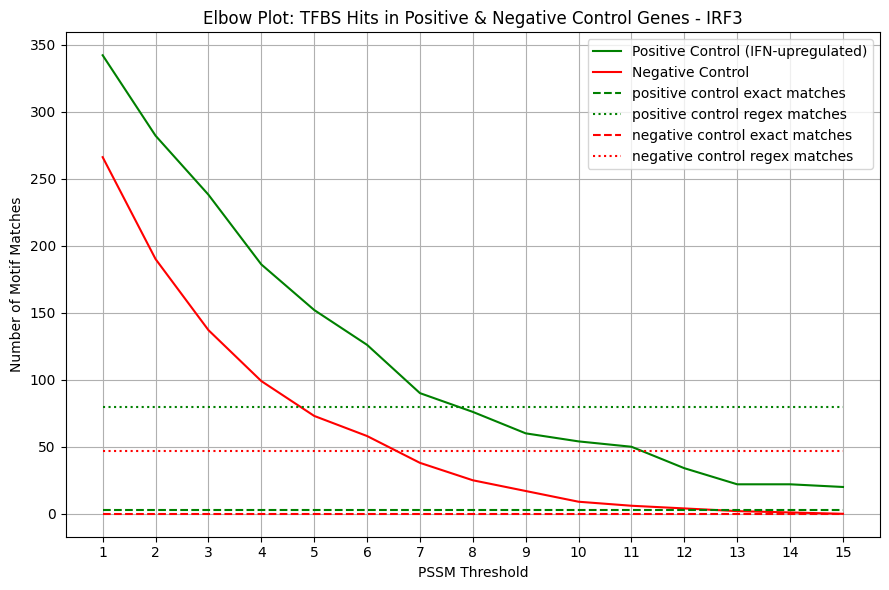

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define base paths
positive_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-9/outputs/positive_IRF3"
negative_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-9/outputs/negative_IRF3"

# Thresholds to evaluate
thresholds = range(1, 16)

# Empty lists to hold match counts
pos_hits = []
neg_hits = []

# Loop through thresholds
for threshold in thresholds:
    # Positive control output files
    pos_file = os.path.join(positive_path, f"pos_scan_jaspar_{threshold}.0.csv")
    if os.path.exists(pos_file):
        df_pos = pd.read_csv(pos_file)
        pos_hits.append(len(df_pos))
    else:
        pos_hits.append(0)

    # Negative control output files
    neg_file = os.path.join(negative_path, f"neg_scan_jaspar_{threshold}.0.csv")
    if os.path.exists(neg_file):
        df_neg = pd.read_csv(neg_file)
        neg_hits.append(len(df_neg))
    else:
        neg_hits.append(0)

# Plot both lines
plt.figure(figsize=(9, 6))
plt.plot(thresholds, pos_hits, linestyle = '-',label="Positive Control (IFN-upregulated)", color="green")
plt.plot(thresholds, neg_hits, linestyle = '-', label="Negative Control", color="red")
#plt.axhline(y=10, color='blue', linestyle='-', linewidth=2, label='positive control exact matches')
plt.plot([1, 15], [3, 3], color='green', linestyle='--', linewidth=1.5, label='positive control exact matches')
plt.plot([1, 15], [80, 80], color='green', linestyle=':', linewidth=1.5, label='positive control regex matches')

plt.plot([1, 15], [0, 0], color='red', linestyle='--', linewidth=1.5, label='negative control exact matches')
plt.plot([1, 15], [47, 47], color='red', linestyle=':', linewidth=1.5, label='negative control regex matches')

plt.xlabel("PSSM Threshold")
plt.ylabel("Number of Motif Matches")
plt.title("Elbow Plot: TFBS Hits in Positive & Negative Control Genes - IRF3")
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

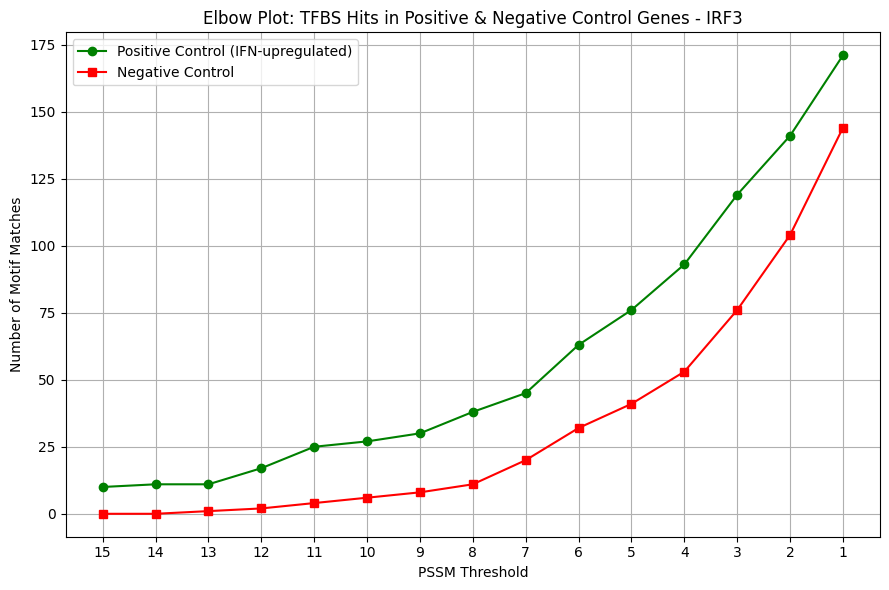

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define base paths
positive_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/TFBS-explorer/outputs/positive_IRF3"
negative_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/TFBS-explorer/outputs/negative_IRF3"

# Thresholds to evaluate
thresholds = range(1, 16)

# Empty lists to hold match counts
pos_hits = []
neg_hits = []

# Loop through thresholds
for threshold in thresholds:
    # Positive control output files
    pos_file = os.path.join(positive_path, f"pos_scan_jaspar_{threshold}.0.csv")
    if os.path.exists(pos_file):
        df_pos = pd.read_csv(pos_file)
        pos_hits.append(len(df_pos))
    else:
        pos_hits.append(0)

    # Negative control output files
    neg_file = os.path.join(negative_path, f"neg_scan_jaspar_{threshold}.0.csv")
    if os.path.exists(neg_file):
        df_neg = pd.read_csv(neg_file)
        neg_hits.append(len(df_neg))
    else:
        neg_hits.append(0)

# Plot both lines
plt.figure(figsize=(9, 6))
plt.plot(thresholds, pos_hits, marker='o', label="Positive Control (IFN-upregulated)", color="green")
plt.plot(thresholds, neg_hits, marker='s', label="Negative Control", color="red")

plt.xlabel("PSSM Threshold")
plt.ylabel("Number of Motif Matches")
plt.title("Elbow Plot: TFBS Hits in Positive & Negative Control Genes - IRF3")
plt.xticks(thresholds)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.gca().invert_xaxis()
plt.show()

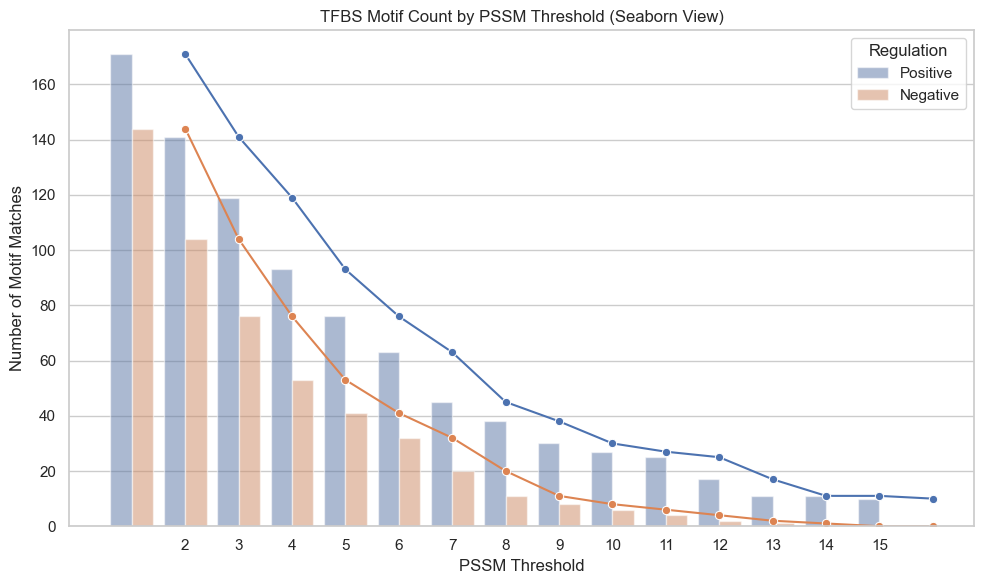

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Base directories
positive_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/TFBS-explorer/outputs/positive_IRF3"
negative_path = "/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/TFBS-explorer/outputs/negative_IRF3"

# Thresholds to evaluate
thresholds = range(1, 16)

# Store records for tidy DataFrame
records = []

# Loop through thresholds
for threshold in thresholds:
    # Positive
    pos_file = os.path.join(positive_path, f"pos_scan_jaspar_{threshold}.0.csv")
    pos_count = len(pd.read_csv(pos_file)) if os.path.exists(pos_file) else 0
    records.append({"Threshold": threshold, "Count": pos_count, "Regulation": "Positive"})

    # Negative
    neg_file = os.path.join(negative_path, f"neg_scan_jaspar_{threshold}.0.csv")
    neg_count = len(pd.read_csv(neg_file)) if os.path.exists(neg_file) else 0
    records.append({"Threshold": threshold, "Count": neg_count, "Regulation": "Negative"})

# Convert to tidy DataFrame
df = pd.DataFrame(records)

# Seaborn plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Bar plot (histogram-like)
sns.barplot(data=df, x="Threshold", y="Count", hue="Regulation", dodge=True, alpha=0.5)

# Line plot
sns.lineplot(data=df, x="Threshold", y="Count", hue="Regulation", marker="o", legend=False)

plt.title("TFBS Motif Count by PSSM Threshold (Seaborn View)")
plt.xlabel("PSSM Threshold")
plt.ylabel("Number of Motif Matches")
plt.xticks(thresholds)
plt.tight_layout()
plt.show()

In [ ]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Visualise the hit number by location

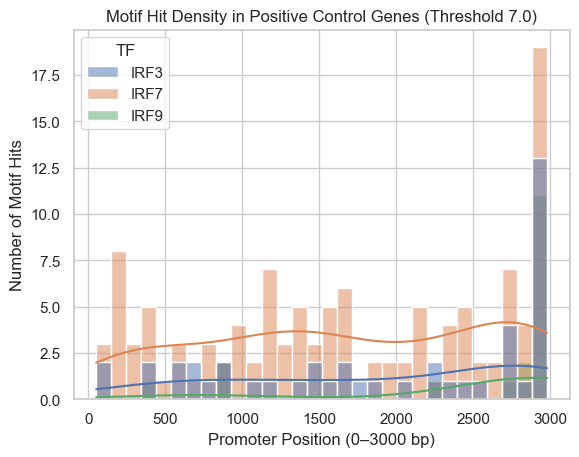

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pos_7 = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

sns.histplot(data = pos_7, bins=30, x='Start', hue= 'TF', kde=True)

plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Density in Positive Control Genes (Threshold 7.0)")
plt.show()

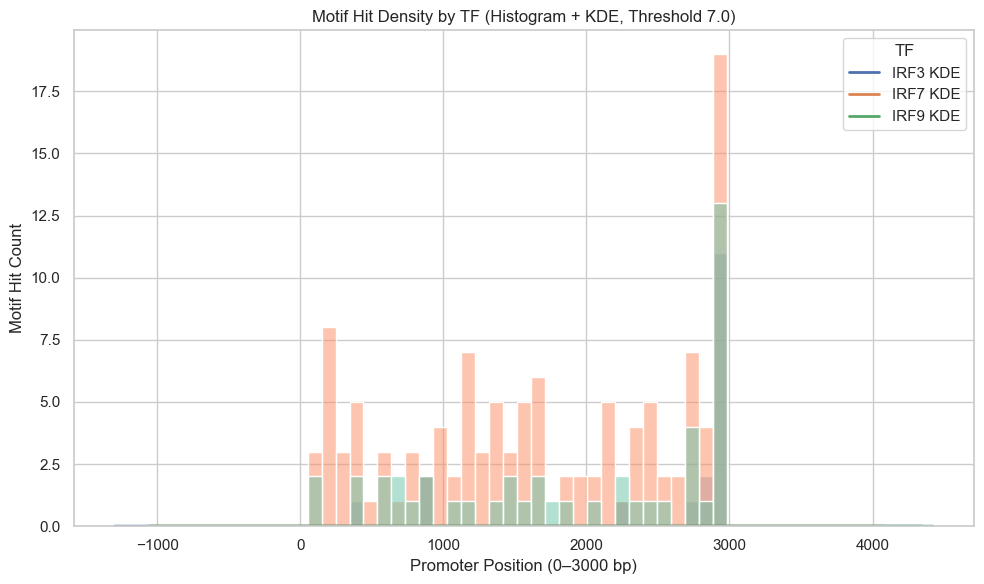

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Set figure
plt.figure(figsize=(10, 6))

# Plot histogram
sns.histplot(data=df, x="Start", hue="TF", bins=30, stat="count", common_norm=False, palette="Set2")

# Overlay correct KDE lines by looping
for tf in df["TF"].unique():
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        label=f"{tf} KDE",
        lw=2,
    )

# Labels and title
plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Motif Hit Count")
plt.title("Motif Hit Density by TF (Histogram + KDE, Threshold 7.0)")
plt.legend(title="TF")
plt.tight_layout()
plt.show()

#### Histogram and KDE density plot to see distribution of TFs

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/1480799023.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend(loc="upper left", title="TF")


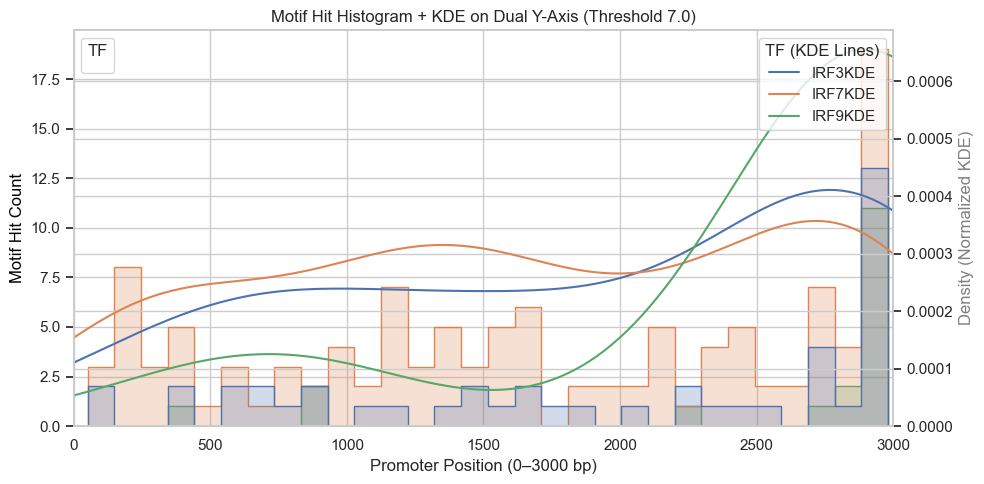

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot histogram on left y-axis (count)
sns.histplot(
    data=df,
    x="Start", # X-axis value
    hue="TF", # Show the different IRFs
    bins=30, # Divide the 3000 by 30
    ax=ax1,
    element="step", 
    stat="count",     # Raw count
    common_norm=False # Do not nomalise
)
ax1.set_ylabel("Motif Hit Count", color="black")
ax1.set_xlabel("Promoter Position (0–3000 bp)")

# Create second y-axis for KDE (density)
ax2 = ax1.twinx()

# Plot KDE curves on right y-axis
for tf in df["TF"].unique(): 
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        ax=ax2,
        label= tf + "KDE",
        fill=False,
        common_norm=True
    )

ax2.legend(title="TF (KDE Lines)", loc="upper right")
ax2.set_ylabel("Density (Normalized KDE)", color="gray")

# Titles and legend
plt.title("Motif Hit Histogram + KDE on Dual Y-Axis (Threshold 7.0)")
ax1.legend(loc="upper left", title="TF")
plt.xlim(0, 3000)
plt.tight_layout()
plt.show()

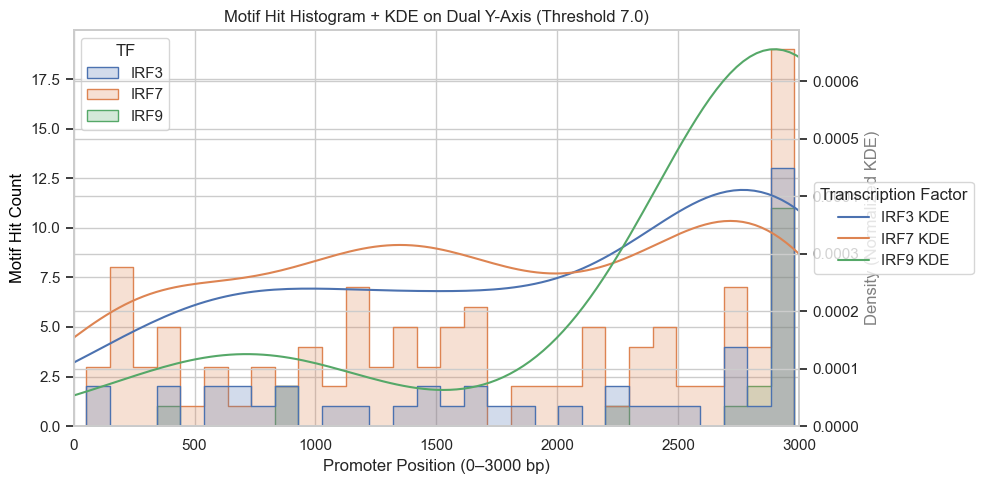

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load the data
df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv')

# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot histogram on left y-axis (count)
sns.histplot(
    data=df,
    x="Start",
    hue="TF",
    bins=30,
    ax=ax1,
    element="step",
    stat="count",
    common_norm=False,
)

ax1.set_ylabel("Motif Hit Count", color="black")
ax1.set_xlabel("Promoter Position (0–3000 bp)")
ax1.set_xlim(0, 3000)

# Create second y-axis for KDE (density)
ax2 = ax1.twinx()

# Plot KDE curves on right y-axis
for tf in df["TF"].unique():
    sns.kdeplot(
        data=df[df["TF"] == tf],
        x="Start",
        ax=ax2,
        label=f"{tf} KDE",
        fill=False,
        common_norm=True
    )

ax2.set_ylabel("Density (Normalized KDE)", color="gray")

# Combine legend entries from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Place combined legend on the right side
ax2.legend(
    handles=handles1 + handles2,
    labels=labels1 + labels2,
    title="Transcription Factor",
    loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

# Title and layout
plt.title("Motif Hit Histogram + KDE on Dual Y-Axis (Threshold 7.0)")
plt.tight_layout()
plt.show()

#### Line plot to see the exact hit numbers between TFs

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/2376518236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")


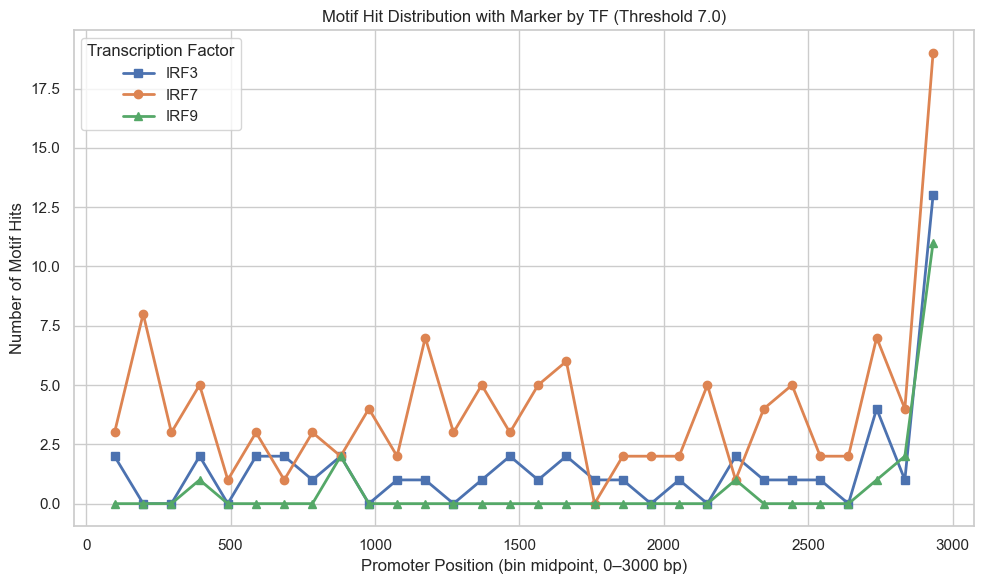

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the motif scan CSV
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# 2. Bin the 'Start' positions (0–3000bp into 30 bins)
df["bin"] = pd.cut(df["Start"], bins=30)

# 3. Group by TF and bin, count hits
counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")

# 4. Convert each bin to midpoint (x value)
counts["bin_mid"] = counts["bin"].apply(lambda x: x.mid)

# 5. Define custom markers for each TF
marker_map = {"IRF3": "s", "IRF7": "o", "IRF9": "^"}  # square, circle, triangle

# 6. Plot with Matplotlib (for full control)
plt.figure(figsize=(10, 6))

# 7. Loop through TFs and plot individually
for tf in counts["TF"].unique():
    subset = counts[counts["TF"] == tf]
    plt.plot(subset["bin_mid"], subset["count"],
             marker=marker_map[tf],  # shape for each TF
             label=tf,
             linestyle='-',          # connect with lines
             linewidth=2)

# 8. Customize the plot
plt.xlabel("Promoter Position (bin midpoint, 0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Distribution with Marker by TF (Threshold 7.0)")
plt.legend(title="Transcription Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/2376518236.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")


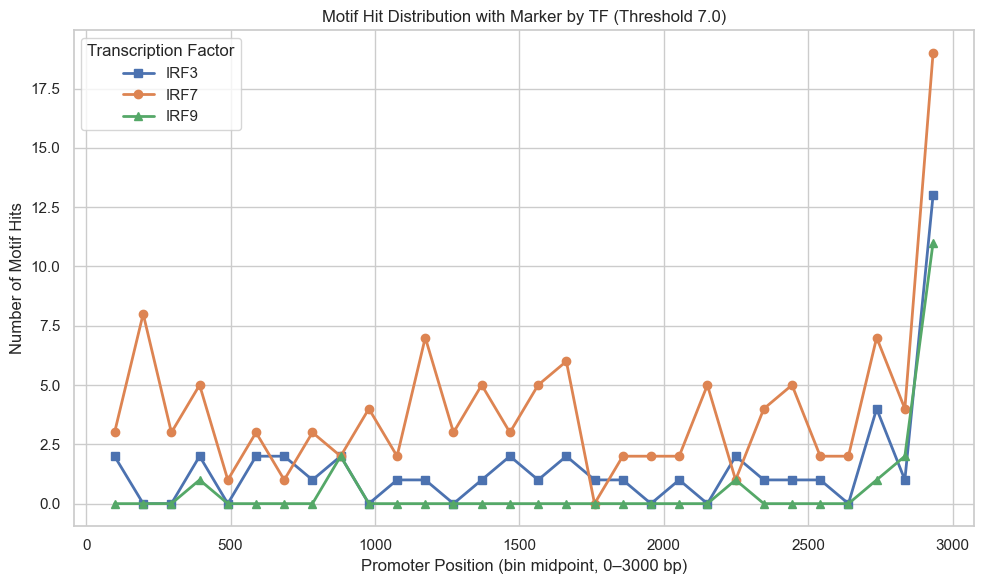

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the motif scan CSV
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# 2. Bin the 'Start' positions (0–3000bp into 30 bins)
df["bin"] = pd.cut(df["Start"], bins=30)

# 3. Group by TF and bin, count hits
counts = df.groupby(["TF", "bin"]).size().reset_index(name="count")

# 4. Convert each bin to midpoint (x value)
counts["bin_mid"] = counts["bin"].apply(lambda x: x.mid)

# 5. Define custom markers for each TF
marker_map = {"IRF3": "s", "IRF7": "o", "IRF9": "^"}  # square, circle, triangle

# 6. Plot with Matplotlib (for full control)
plt.figure(figsize=(10, 6))

# 7. Loop through TFs and plot individually
for tf in counts["TF"].unique():
    subset = counts[counts["TF"] == tf]
    plt.plot(subset["bin_mid"], subset["count"],
             marker=marker_map[tf],  # shape for each TF
             label=tf,
             linestyle='-',          # connect with lines
             linewidth=2)

# 8. Customize the plot
plt.xlabel("Promoter Position (bin midpoint, 0–3000 bp)")
plt.ylabel("Number of Motif Hits")
plt.title("Motif Hit Distribution with Marker by TF (Threshold 7.0)")
plt.legend(title="Transcription Factor")
plt.grid(True)
plt.tight_layout()
plt.show()

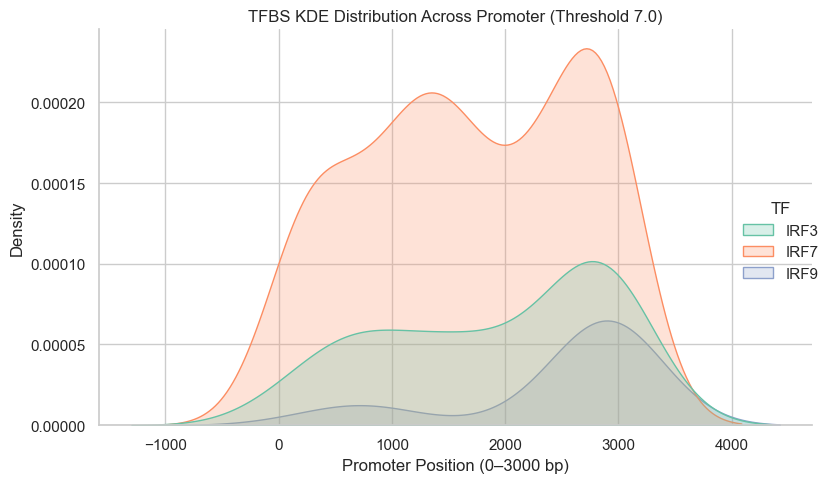

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Create the KDE plot using displot
sns.displot(
    data=df,
    x="Start",
    hue="TF",
    kind="kde",             # Smooth distribution
    height=5,
    aspect=1.5,
    multiple="layer",       # Overlay KDEs
    palette="Set2",
    fill=True               # Fill area under the curve (optional)
)

# Labeling must go under plt.gca() when using displot
plt.xlabel("Promoter Position (0–3000 bp)")
plt.ylabel("Density")
plt.title("TFBS KDE Distribution Across Promoter (Threshold 7.0)")
plt.tight_layout()
plt.show()

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_12275/3871992153.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["TF", "bin"]).size().reset_index(name="Count")


<Axes: xlabel='Mid', ylabel='Count'>

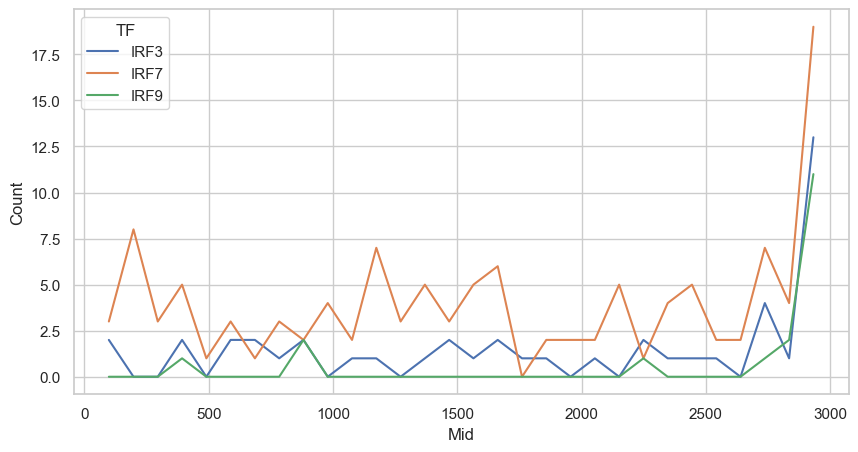

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Load data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Bin the 'Start' position into 30 equal bins from 0–3000 bp
df["bin"] = pd.cut(df["Start"], bins=30)

# Count number of hits per bin per TF
binned = df.groupby(["TF", "bin"]).size().reset_index(name="Count")

# Compute bin midpoints to use for x-axis
binned["Mid"] = binned["bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10, 5))
sns.lineplot(data=binned, x='', y='Count', hue='TF', markers='o')

#### IRF3 Scan results visualisation

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='whitegrid')

# Load data
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-4/outputs/positive/motif_scan_positive_threshold_7.0.csv")

# Bin the 'Start' position into 30 equal bins from 0–3000 bp
df["bin"] = pd.cut(df["Start"], bins=30)

# Count number of hits per bin per TF
binned = df.groupby(["TF", "bin"]).size().reset_index(name="Count")

# Compute bin midpoints to use for x-axis
binned["Mid"] = binned["bin"].apply(lambda x: x.mid)

plt.figure(figsize=(10, 5))
sns.lineplot(data=binned, x='', y='Count', hue='TF', markers='o')

## Visualisation motif scan results by methods (Exact, Regex, JASPAR)
#### pssm threshold with 3.0

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
175  JASPAR   Negative  1550.0      2
176  JASPAR   Negative  1850.0      0
177  JASPAR   Negative   850.0      3
178  JASPAR   Negative  2050.0      2
179  JASPAR   Negative   950.0      2

[180 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/1789621904.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


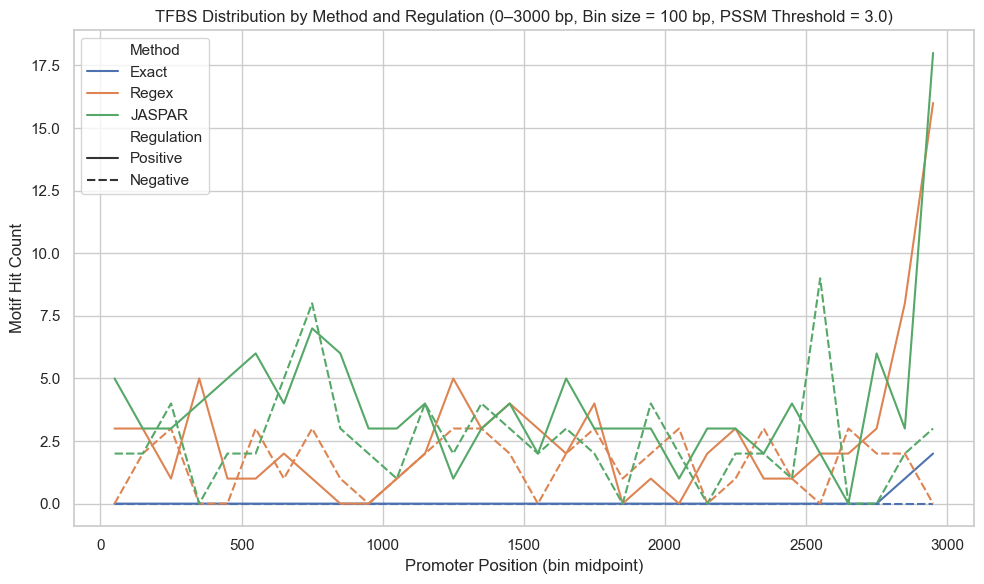

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_jaspar_3.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_jaspar_3.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 3.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### PSSM Threshold 5.0

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
175  JASPAR   Negative  1550.0      0
176  JASPAR   Negative  1850.0      0
177  JASPAR   Negative   850.0      1
178  JASPAR   Negative  2050.0      2
179  JASPAR   Negative   950.0      0

[180 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/500923118.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


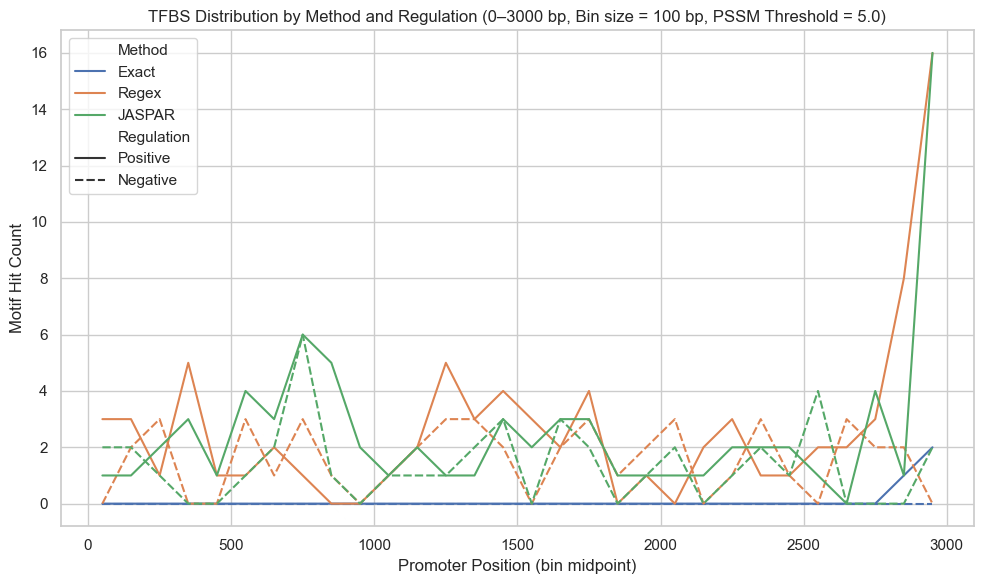

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_jaspar_5.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_jaspar_5.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 5.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### PSSM Threshold 7.0

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
175  JASPAR   Negative  1550.0      0
176  JASPAR   Negative  1850.0      0
177  JASPAR   Negative   850.0      1
178  JASPAR   Negative  2050.0      1
179  JASPAR   Negative   950.0      0

[180 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/3922120148.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


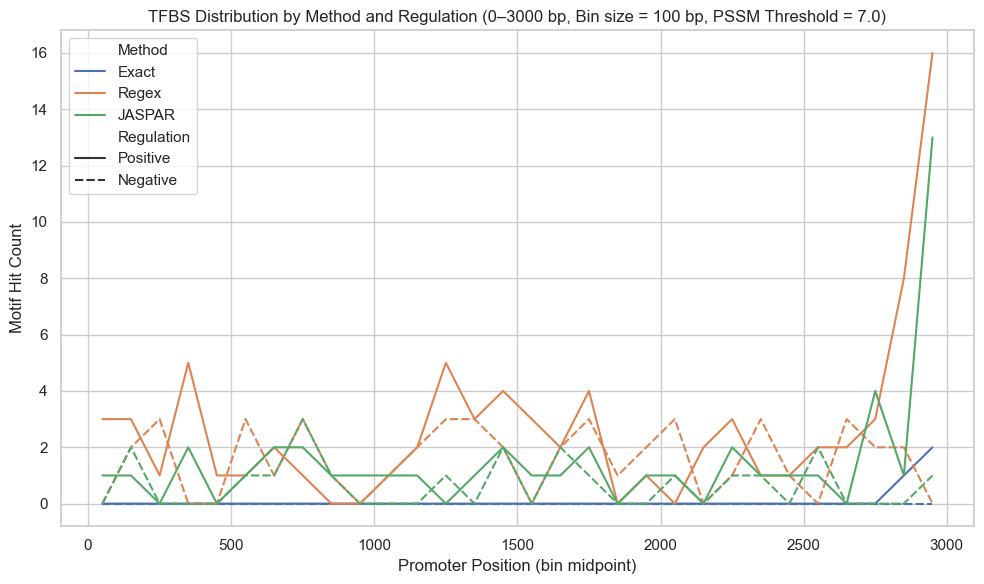

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_jaspar_7.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_jaspar_7.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 7.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### PSSM Threshold 9.0

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
175  JASPAR   Negative  1550.0      0
176  JASPAR   Negative  1850.0      0
177  JASPAR   Negative   850.0      1
178  JASPAR   Negative  2050.0      0
179  JASPAR   Negative   950.0      0

[180 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/223096498.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


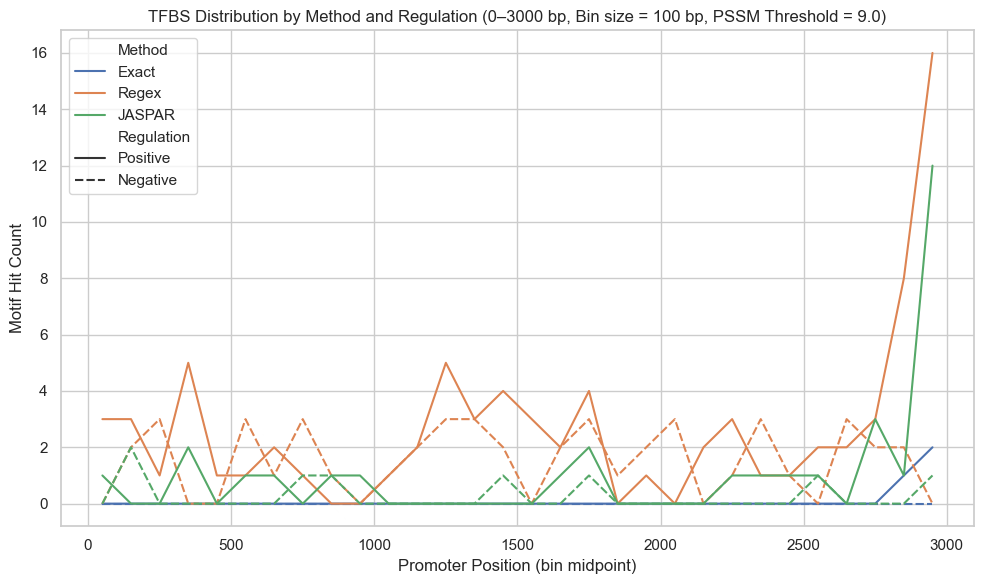

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/positive_IRF3/pos_scan_jaspar_9.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/negative_IRF3/neg_scan_jaspar_9.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 9.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

#### PSSM Threshold 11.0

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
169  JASPAR   Negative   550.0      0
170  JASPAR   Negative  1550.0      0
171  JASPAR   Negative  1850.0      0
172  JASPAR   Negative   850.0      0
173  JASPAR   Negative  2050.0      0

[174 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/1000016188.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


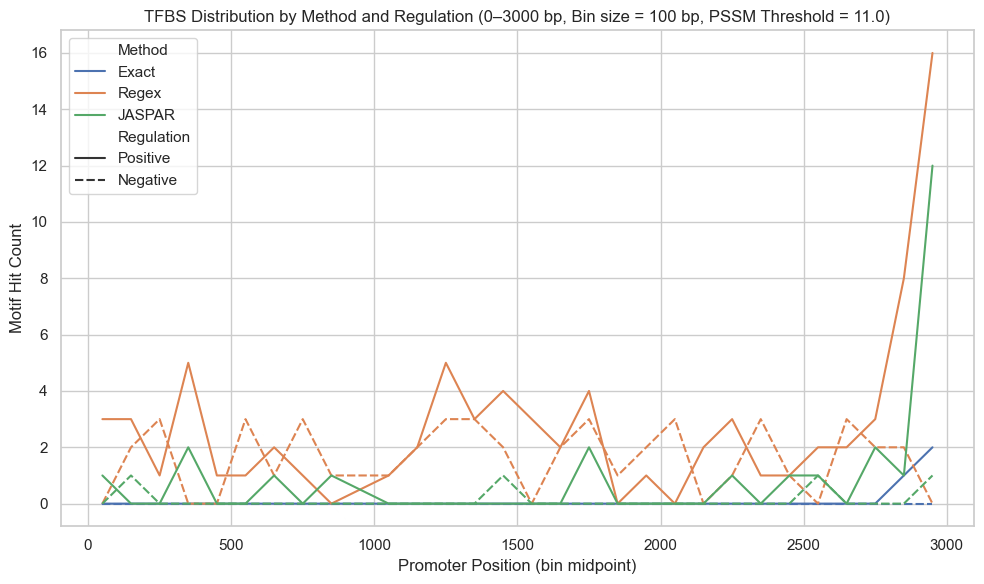

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/positive_IRF3/pos_scan_jaspar_11.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/negative_IRF3/neg_scan_jaspar_11.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 11.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

     Method Regulation     Mid  Count
0     Exact   Positive  2850.0      1
1     Exact   Positive  2950.0      2
2     Exact   Positive  1950.0      0
3     Exact   Positive  2750.0      0
4     Exact   Positive  2250.0      0
..      ...        ...     ...    ...
169  JASPAR   Negative   550.0      0
170  JASPAR   Negative  1550.0      0
171  JASPAR   Negative  1850.0      0
172  JASPAR   Negative   850.0      0
173  JASPAR   Negative  2050.0      0

[174 rows x 4 columns]


/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_96671/2442907260.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")


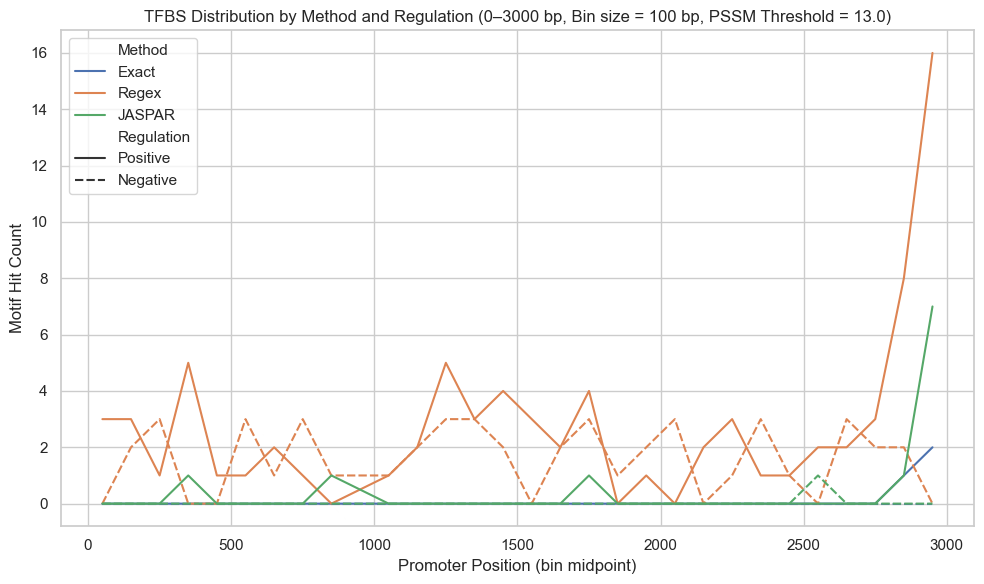

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_exact_results.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/positive_IRF3/pos_scan_regex_results.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/positive_IRF3/pos_scan_jaspar_13.0.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_exact_results.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-7/outputs/negative_IRF3/neg_scan_regex_results.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-8/outputs/negative_IRF3/neg_scan_jaspar_13.0.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 3000, 31)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid)

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)

## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–3000 bp, Bin size = 100 bp, PSSM Threshold = 13.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import requests
import csv

# Set the dict to store gene_id and gene_name
gene_ids = {}

positive_control = "/Users/sang/bioinformatics_msc_project_2025/github/TFBS-explorer/Inputs/human_IFN_up-regulation.csv"

with open(positive_control, "r") as file:
    next(file)
    for line in file:
        data = line.split(",")
        gene_id = data[1]
        gene_name = data[2]
        gene_ids[gene_name] = gene_id

print(f"Loaded {len(gene_ids)} genes from CSV using index-based parsing.")

# Set the server database to retrieve
server = "https://rest.ensembl.org"
headers = {"Accept": "application/json"}

# Set the Gene_names and ids
# write a fasta file for promoter sequences
with open("fetch_sequence.csv", "w") as fasta_file:
    for gene_name, gene_id in gene_ids.items():
        # Set the endpoint to get 5' end expanded sequences
        endpoint = f"/sequence/id/{gene_id}?expand_5prime=3000"
        url = server + endpoint

        r = requests.get(url, headers=headers)

        if not r.ok:
            print(f"Error while retrieve {gene_name}: {r.status_code}") # need to change gene_name to gene_id for further analysis Ensembl IDs are unique but gene_names are not unique. Same gene can be presented multiple species.
            continue
        
        data = r.json() # Store extract data in json format
        sequence = data.get('seq', '') # extract the sequence from data in json format
        trimmedsequence = sequence[:50]

        cdna_url = f'{server}/sequence/id/{gene_id}?type=cdna'
        cdna = requests.get(cdna_url, headers=headers)
        if not cdna.ok:
            print(f'Error while retrieve cDNA')
            continue
        cdna_data = cdna.json()
        cdna_seq = cdna_data.get('seq', '')

        cds_url = f'{server}/sequence/id/{gene_id}?type=cds'
        cds = requests.get(cds_url, headers=headers)
        if not cds.ok:
            print(f'Error retrieve CDS')
            continue
        cds_data = cds.json()
        cds_seq = cds_data.get('seq','')


        # Write the fasta file row
        
        #print(trimmedsequence)
        print(cdna_seq)
        print(cds_seq)
        
        # Print to check
        #print(f">{gene_name}_{gene_id}\n{trimmedsequence}\n")


Loaded 100 genes from CSV using index-based parsing.
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
Error while retrieve cDNA
AGAACTCTGTGGATGAACCTTGAAGGAGCCTCCAAGCCTGAACCAAAGCACTACAGATCACCTGCTATCTTCATAGCACCATGAGTGAAGAATCTGATGGAAAGCTTATTGAAGACAGCCTGATTCAGCTGAGATGTCACTTTACATGGAAGTTGTTAATTGAAGCCCCTGAAATTCCTGATTTAGAAAACAGGATCTGGGAAGAGATTCAGTTCCTGGACACCAAATACAATGTGGGAATACACAACCTACTAGCCTATGTGAAACACCTGAAAGGCCAGAATGAGGAAGCCCTGGTCAGCTTGAAAAAGGCTGAAGACTTAATTCAGAAAGAACATGCCAACCAAGCAGATATTAGAAGTCTGGTGACCTGGGGCAACTTTGCCTGGGTGTATTACCACATGGGCAGATTGGCAGAAGCCCAGACTTACCTGGACAAGGTGGAGAACACTTGCAAGAAGTTTGCAAATCCTTCCCGCTATAGAATGGAGTGTCCAGAGGTGGACTGTGAGGAAGGATGGGCCTTGGCGAAGTGTGGTGGAAAGAATTATGAACGGGCCAAGACCTGCTTTGAAAAGGCTCTGGAAGGGAACCCTGAAAACCCTGAATTCAATACTGGGTACGCAATCACCGTCTATCGCCTGGATAAATTTAACACAGC

In [ ]:
import pandas as pd

# Load the CSV file
input_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_regex.csv'
df = pd.read_csv(input_file)

irf9_df = df[df['Transcription_Factor'] == 'IRF9']
#irf9_df = irf9_df[irf9_df['Sequence_Type'] == 'Genomic']
count = len(irf9_df)

print(f"Number of IRF9 hits: {count}")



Number of IRF9 hits: 38


In [ ]:
## To check the number of IRF9 hits in the match output.csv file

import pandas as pd

# Load the CSV file
input_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_regex.csv'
df = pd.read_csv(input_file)

irf9_df = df[df['Transcription_Factor'] == 'IRF9']
#irf9_df = irf9_df[irf9_df['Sequence_Type'] == 'Genomic']
count = len(irf9_df)

print(f"Number of IRF9 hits: {count}")



Number of IRF9 hits: 980


#### Generate Lollipop plot

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

input_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv'
input_df = pd.read_csv('input.csv')

# Extract unique transcription factors (TFs) from the DataFrame
unique_tfs = input_df['Transcription_Factor'].unique()

# Create a color map for each unique TF
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(unique_tfs))]

# Create a dictionary to map each TF to a color
# Assign colors to each unique TF
tf_colors = dict(zip(unique_tfs, colors))

# Create a height for each unique TF
# Use a linear space to assign heights
heights = np.linsppace(0.15, 0.15* len(unique_tfs), len(unique_tfs))

# Create a dictionary to map each TF to a height
# Assign heights to each unique TF
tf_heights = dict(zip(unique_tfs, heights))

# Add 'Height' and 'Color' columns to the DataFrame
input_df['Height'] = input_df['Transcription_Factor'].map(tf_heights)
input_df['Color'] = input_df['Transcription_Factor'].map(tf_colors)

# Loop over each unique gene name
for gene_name in input_df['Gene_Name'].unique():
    df = input_df[input_df['Gene_Name'] == gene_name]

    # make a plot
    plt.figure(figsize=(6, 2))

    # Plot the lollipop plot for the specified gene
    for _, row in df.iterrows():
        plt.vlines(row['Start'], 0, row['line_height'], color=row['tf_colour'])

    plt.scatter(df['Start'], df['line_height'], color=df['tf_colour'], s=60, zorder=3, alpha=0.8)

    # Add a vertical dashed line at x=0 to indicate the transcription start site (TSS)
    plt.yticks([])
    plt.ylim(0, 1.5)

    # Set the title and labels for the plot
    plt.xlabel('TFBS position relative to TSS')
    plt.xlim(0, 500)
    plt.xticks(
        ticks=[0, 100, 200, 300, 400, 500],
        labels=['-500', '-400', '-300', '-200', '-100', '+1']
    )

    # Create legend
    legend_handles = [mpatches.Patch(color=color, label=tf) for tf, color in tf_colors.items()]
    plt.legend(handles=legend_handles, title="Transcription factor", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Save each plot with a gene-specific filename
    plt.tight_layout()
    plt.savefig(f'{gene_name}_tfbs_positions_lollipop_plot.svg', format='svg', bbox_inches='tight')
    plt.close()  # Important: close the plot to avoid memory issues

    print(f"Saved plot for {gene_name}")


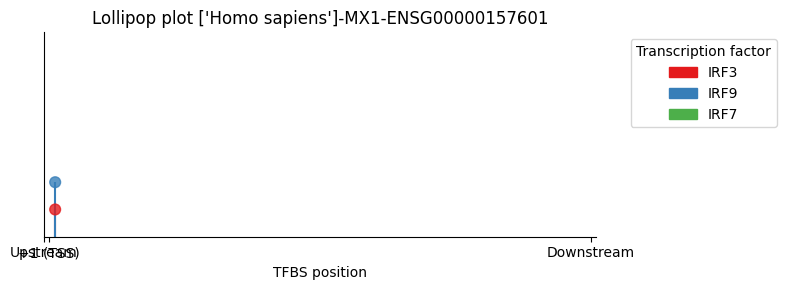

In [38]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Read input files
match_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv'
seq_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_up_regulation_extract.csv'

# Crates dataframe for each input file
match_df = pd.read_csv(match_file)
seq_df = pd.read_csv(seq_file)

# Make a list with Transcriptioin Factors
unique_tfs = match_df['Transcription_Factor'].unique()

# Make a color list with unique tfs numbers
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(unique_tfs))]

# Creates dict to assign color for each TF
tf_colors = dict(zip(unique_tfs, colors))

# Set up the each TF height
# Assigns each height to unique TFs e.g., IRF3: 0.15, IRF7: 0.3...
heights = np.linspace(0.2, 0.2 * len(unique_tfs), len(unique_tfs))
tf_heights = dict(zip(unique_tfs, heights))

# Add color and height to match result dataframe
match_df['Color'] = match_df['Transcription_Factor'].map(tf_colors)
match_df['Height'] = match_df['Transcription_Factor'].map(tf_heights)

# Create plots
# Iterates over genes in match dataframe
for gene_name in match_df['Gene_Name'].unique():
    df = match_df[match_df['Gene_Name'] == gene_name].copy()

    seq_row = seq_df[seq_df['gene_name'] == gene_name]

    upstream_len = len(str(seq_row.iloc[0]['Upstream']))
    gene_len = len(str(seq_row.iloc[0]['Gene_seq']))
    downstream_len = len(str(seq_row.iloc[0]['Downstream']))

    # Shift start positions relative to TSS
    df['Rel_Start'] = df['Start'] - upstream_len

    plt.figure(figsize=(8, 3))

    # Vertical lines for TFBS hits
    for _, row in df.iterrows():
        plt.vlines(row['Rel_Start'], 0, row['Height'], color=row['Color'])

    # Scatter points at TFBS positions
    plt.scatter(df['Rel_Start'], df['Height'], color=df['Color'], s=60, zorder=3, alpha=0.8)

    plt.title(f'Lollipop plot {species}-{gene_name}-{gene_id}')
    plt.yticks([])
    plt.ylim(0, 1.5)

    plt.xlabel('TFBS position')
    plt.xlim(-upstream_len, gene_len + downstream_len) 
    tick_locs = [-upstream_len, 1, (gene_len + downstream_len) - downstream_len]
    tick_labels = ['Upstream', '+1 (TSS)', 'Downstream']

    plt.xticks(tick_locs, tick_labels)

    # Create legend
    legend_handles = [mpatches.Patch(color=color, label=tf) for tf, color in tf_colors.items()]
    plt.legend(handles=legend_handles, title="Transcription factor", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Save each plot with a gene-specific filename
    plt.tight_layout()
    plt.savefig(f'{gene_name}_tfbs_positions_lollipop_plot.svg', format='svg', bbox_inches='tight')
    plt.show()
    plt.close() # Important: close the plot to avoid memory issues
    break



In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Read input files
match_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv'
seq_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_up_regulation_extract.csv'

# Crates dataframe for each input file
match_df = pd.read_csv(match_file)
seq_df = pd.read_csv(seq_file)

# Make a list with Transcriptioin Factors
unique_tfs = match_df['Transcription_Factor'].unique()

# Make a color list with unique tfs numbers
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(unique_tfs))]

# Creates dict to assign color for each TF
tf_colors = dict(zip(unique_tfs, colors))

# Set up the each TF height
# Assigns each height to unique TFs e.g., IRF3: 0.15, IRF7: 0.3...
heights = np.linspace(0.2, 0.2 * len(unique_tfs), len(unique_tfs))
tf_heights = dict(zip(unique_tfs, heights))

# Add color and height to match result dataframe
match_df['Color'] = match_df['Transcription_Factor'].map(tf_colors)
match_df['Height'] = match_df['Transcription_Factor'].map(tf_heights)

# Create plots
# Iterates over genes in match dataframe
for gene_name in match_df['Gene_Name'].unique():
    df = match_df[match_df['Gene_Name'] == gene_name].copy()
    df = match_df[match_df['Sequence_Type'] == 'Genomic']

    seq_row = seq_df[seq_df['gene_name'] == gene_name]

    upstream_len = len(str(seq_row.iloc[0]['Upstream']))
    gene_len = len(str(seq_row.iloc[0]['Gene_seq']))
    downstream_len = len(str(seq_row.iloc[0]['Downstream']))

    # Shift start positions relative to TSS
    df['Rel_Start'] = df['Start'] - upstream_len

    plt.figure(figsize=(8, 3))

    # Vertical lines for TFBS hits
    for _, row in df.iterrows():
        plt.vlines(row['Rel_Start'], 0, row['Height'], color=row['Color'])

    # Scatter points at TFBS positions
    plt.scatter(df['Rel_Start'], df['Height'], color=df['Color'], s=60, zorder=3, alpha=0.8)

    plt.title(f'Lollipop plot {species}-{gene_name}-{gene_id}')
    plt.yticks([])
    plt.ylim(0, 1.5)

    plt.xlabel('TFBS position')
    plt.xlim(-upstream_len, gene_len + downstream_len) 
    tick_locs = [-upstream_len, 1, (gene_len + downstream_len) - downstream_len]
    tick_labels = ['Upstream', '+1 (TSS)', 'Downstream']

    plt.xticks(tick_locs, tick_labels)

    # Create legend
    legend_handles = [mpatches.Patch(color=color, label=tf) for tf, color in tf_colors.items()]
    plt.legend(handles=legend_handles, title="Transcription factor", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Save each plot with a gene-specific filename
    plt.tight_layout()
    plt.savefig(f'{gene_name}_tfbs_positions_lollipop_plot.svg', format='svg', bbox_inches='tight')
    plt.show()
    plt.close() # Important: close the plot to avoid memory issues
    break



1


#### Stack when matches located at same position

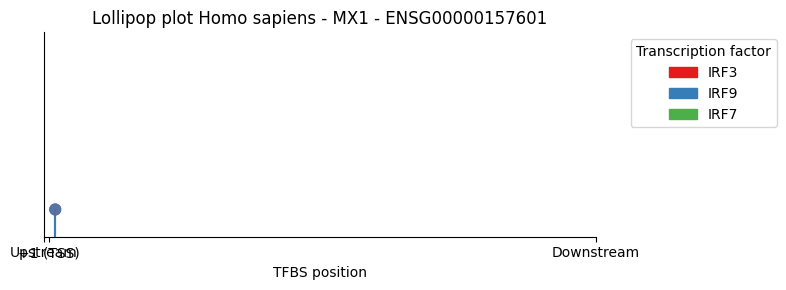

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Input files ===
match_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_exact.csv'
seq_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_up_regulation_extract.csv'

# === Load data ===
match_df = pd.read_csv(match_file)
seq_df = pd.read_csv(seq_file)

# === Filter to genomic only ===
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']

# === Assign colors ===
unique_tfs = match_df['Transcription_Factor'].unique()
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(unique_tfs))]
tf_colors = dict(zip(unique_tfs, colors))
match_df['Color'] = match_df['Transcription_Factor'].map(tf_colors)

# === Loop through genes ===
for gene_name in match_df['Gene_Name'].unique():
    df = match_df[match_df['Gene_Name'] == gene_name].copy()
    seq_row = seq_df[seq_df['gene_name'] == gene_name]

    if seq_row.empty:
        continue

    # === Get sequence lengths ===
    upstream_len = len(str(seq_row.iloc[0]['Upstream']))
    gene_len = len(str(seq_row.iloc[0]['Gene_seq']))
    downstream_len = len(str(seq_row.iloc[0]['Downstream']))

    # === Relative position to TSS ===
    df['Rel_Start'] = df['Start'] - upstream_len

    # === STACKING FIX: sort + group by position + assign stack level ===
    df.sort_values(by=['Rel_Start', 'Transcription_Factor'], inplace=True)
    df['Stack_Level'] = df.groupby(['Rel_Start', 'Transcription_Factor']).cumcount()
    base_height = 0.2
    df['line_height'] = df['Stack_Level'] * base_height + base_height

    # === Plot ===
    plt.figure(figsize=(8, 3))

    # Vertical lines
    for _, row in df.iterrows():
        plt.vlines(row['Rel_Start'], 0, row['line_height'], color=row['Color'])

    # Scatter points
    plt.scatter(df['Rel_Start'], df['line_height'], color=df['Color'], s=60, zorder=3, alpha=0.8)

    # Labels and limits
    species = seq_row.iloc[0]['species']
    gene_id = seq_row.iloc[0]['ensembl_id']
    plt.title(f'Lollipop plot {species} - {gene_name} - {gene_id}')
    plt.yticks([])
    plt.ylim(0, 1.5)
    plt.xlabel('TFBS position')
    plt.xlim(-upstream_len, gene_len + downstream_len)
    tick_locs = [-upstream_len, 1, gene_len + downstream_len]
    tick_labels = ['Upstream', '+1 (TSS)', 'Downstream']
    plt.xticks(tick_locs, tick_labels)

    # Legend
    legend_handles = [mpatches.Patch(color=color, label=tf) for tf, color in tf_colors.items()]
    plt.legend(handles=legend_handles, title="Transcription factor", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Aesthetics
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # Save and show
    plt.tight_layout()
    plt.savefig(f'{gene_name}_tfbs_positions_lollipop_plot.svg', format='svg', bbox_inches='tight')
    plt.show()
    plt.close()

    # Remove this break if you want to run for all genes
    break

#### Set the each TF height 0 to 0.2, 0.2 to 0.4, 0.4 to 0.6...

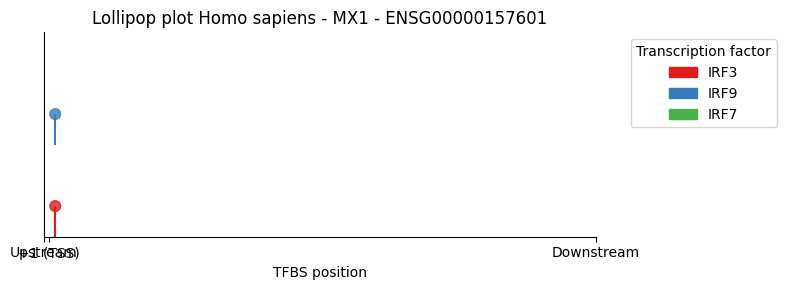

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Input files ===
match_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_exact.csv'
seq_file = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_up_regulation_extract.csv'

# === Load data ===
match_df = pd.read_csv(match_file)
seq_df = pd.read_csv(seq_file)

# === Filter to genomic only ===
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']

# === Define fixed height ranges for each TF ===
height_ranges = {
    'IRF3': (0.00, 0.3),
    'IRF7': (0.3, 0.60),
    'IRF9': (0.90, 1.2),
}

# === Assign colors ===
unique_tfs = match_df['Transcription_Factor'].unique()
cmap = plt.get_cmap('Set1')
colors = [cmap(i) for i in range(len(unique_tfs))]
tf_colors = dict(zip(unique_tfs, colors))
match_df['Color'] = match_df['Transcription_Factor'].map(tf_colors)

# === Assign top of each vertical line by TF ===
match_df['Height'] = match_df['Transcription_Factor'].map(lambda tf: height_ranges.get(tf, (0, 0.15))[1])

# === Loop through genes ===
for gene_name in match_df['Gene_Name'].unique():
    df = match_df[match_df['Gene_Name'] == gene_name].copy()
    seq_row = seq_df[seq_df['gene_name'] == gene_name]

    if seq_row.empty:
        continue

    # === Get sequence lengths ===
    upstream_len = len(str(seq_row.iloc[0]['Upstream']))
    gene_len = len(str(seq_row.iloc[0]['Gene_seq']))
    downstream_len = len(str(seq_row.iloc[0]['Downstream']))

    # === Relative position to TSS ===
    df['Rel_Start'] = df['Start'] - upstream_len

    plt.figure(figsize=(8, 3))

    # === Vertical lines per TF ===
    for _, row in df.iterrows():
        start_y = height_ranges.get(row['Transcription_Factor'], (0, 0.15))[0]
        end_y = row['Height']
        plt.vlines(row['Rel_Start'], start_y, end_y, color=row['Color'])

    # === Add scatter points ===
    plt.scatter(df['Rel_Start'], df['Height'], color=df['Color'], s=60, zorder=3, alpha=0.8)

    # === Labels and limits ===
    species = seq_row.iloc[0]['species']
    gene_id = seq_row.iloc[0]['ensembl_id']
    plt.title(f'Lollipop plot {species} - {gene_name} - {gene_id}')
    plt.yticks([])
    plt.ylim(0, 2)

    plt.xlabel('TFBS position')
    plt.xlim(-upstream_len, gene_len + downstream_len)
    tick_locs = [-upstream_len, 1, gene_len + downstream_len]
    tick_labels = ['Upstream', '+1 (TSS)', 'Downstream']
    plt.xticks(tick_locs, tick_labels)

    # === Create legend ===
    legend_handles = [mpatches.Patch(color=color, label=tf) for tf, color in tf_colors.items()]
    plt.legend(handles=legend_handles, title="Transcription factor", bbox_to_anchor=(1.05, 1), loc='upper left')

    # === Plot aesthetics ===
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

    # === Save ===
    plt.tight_layout()
    plt.savefig(f'{gene_name}_tfbs_positions_lollipop_plot.svg', format='svg', bbox_inches='tight')
    plt.show()
    plt.close()

    break  # remove if you want to run for all genes

In [46]:
import pandas as pd

pos_exact = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_exact.csv'
pos_regex = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_regex.csv'
pos_jaspar = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv'

neg_exact = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_exact.csv'
neg_regex = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_regex.csv'
neg_jaspar = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_jaspar.csv'

df_pos_exact = pd.read_csv(pos_exact)
df_pos_regex = pd.read_csv(pos_regex)
df_pos_jaspar = pd.read_csv(pos_jaspar)

df_neg_exact = pd.read_csv(neg_exact)
df_neg_regex = pd.read_csv(neg_regex)
df_neg_jaspar = pd.read_csv(neg_jaspar)

df_pos_exact = df_pos_exact[df_pos_exact['Sequence_Type'] == 'Genomic']
df_pos_regex = df_pos_regex[df_pos_regex['Sequence_Type'] == 'Genomic']
df_pos_jaspar = df_pos_jaspar[df_pos_jaspar['Sequence_Type'] == 'Genomic']

df_neg_exact = df_neg_exact[df_neg_exact['Sequence_Type'] == 'Genomic']
df_neg_regex = df_neg_regex[df_neg_regex['Sequence_Type'] == 'Genomic']
df_neg_jaspar = df_neg_jaspar[df_neg_jaspar['Sequence_Type'] == 'Genomic']

pos_exact_counts = df_pos_exact['Transcription_Factor'].value_counts()

print(len(df_pos_exact))
print(len(df_pos_regex))

print(len(df_neg_exact))
print(len(df_neg_regex))

56
3030
14
4431


In [ ]:
pos_regex_counts = df_pos_regex['Transcription_Factor'].value_counts()
print(pos_regex_counts)


Transcription_Factor
IRF3    1010
IRF7    1010
IRF9    1010
Name: count, dtype: int64
3


In [25]:
pos_jaspar_counts = df_pos_jaspar['Transcription_Factor'].value_counts()
print(pos_jaspar_counts)

Transcription_Factor
IRF7    128
IRF3    103
IRF9     35
Name: count, dtype: int64


In [26]:
neg_exact_counts = df_neg_exact['Transcription_Factor'].value_counts()
print(neg_exact_counts)

Transcription_Factor
IRF7    8
IRF3    3
IRF9    3
Name: count, dtype: int64


In [27]:
neg_regex_counts = df_neg_regex['Transcription_Factor'].value_counts()
print(neg_regex_counts)

Transcription_Factor
IRF3    1477
IRF7    1477
IRF9    1477
Name: count, dtype: int64


In [28]:
neg_jaspar_counts = df_neg_jaspar['Transcription_Factor'].value_counts()
print(neg_jaspar_counts)
print(len(df_neg_jaspar))

Transcription_Factor
IRF7    125
IRF3     55
IRF9     16
Name: count, dtype: int64
196


## Positive Exact match results

In [29]:
pos_exact_counts = df_pos_exact['Gene_Name'].value_counts()

unique_genes = len(pos_exact_counts)
print(f'Number of unique genes in positive exact matches: {unique_genes}')

max_matches = pos_exact_counts.max()
print(f'Maximum number of matches for a single gene in positive exact matches: {max_matches}')

pos_exact_counts = df_pos_exact['Gene_Name'].value_counts()
print(pos_exact_counts)

Number of unique genes in positive exact matches: 30
Maximum number of matches for a single gene in positive exact matches: 4
Gene_Name
HERC6       4
IRF2        3
PSMB9       3
TAP1        3
MX1         2
SAMHD1      2
ZNFX1       2
SERPINB9    2
TMEM229B    2
TDRD7       2
IRF1        2
DDX60       2
CXCL16      2
RNF213      2
PARP12      2
TRIM14      2
CIITA       2
ZMYND15     2
ISG15       2
TNFSF10     2
IFI27       2
IFIT3       1
IRF7        1
PARP14      1
ATF3        1
CYP2J2      1
MYD88       1
TAP2        1
USP18       1
C19orf66    1
Name: count, dtype: int64


## Positive Regex results

In [30]:
pos_regex_counts = df_pos_regex['Gene_Name'].value_counts()

unique_genes = len(pos_regex_counts)
print(f'Number of unique genes in positive exact matches: {unique_genes}')

max_matches = pos_regex_counts.max()
print(f'Maximum number of matches for a single gene in positive exact matches: {max_matches}')

pos_regex_counts = df_pos_regex['Gene_Name'].value_counts()
print(pos_regex_counts)

Number of unique genes in positive exact matches: 96
Maximum number of matches for a single gene in positive exact matches: 231
Gene_Name
PDZD2      231
TRIM5      195
RNF213      99
ZC3HAV1     99
DDX60       96
          ... 
TREX1        3
HLA-F        3
ZMYND15      3
MYD88        3
IRF7         3
Name: count, Length: 96, dtype: int64


## Positive JASPAR results

In [43]:
pos_jaspar_counts = df_pos_jaspar['Gene_Name'].value_counts()

unique_genes = len(pos_jaspar_counts)
print(f'Number of unique genes in positive exact matches: {unique_genes}')

max_matches = pos_jaspar_counts.max()
print(f'Maximum number of matches for a single gene in positive exact matches: {max_matches}')

pos_jaspar_counts = df_pos_jaspar['Gene_Name'].value_counts()
print(pos_jaspar_counts)

Number of unique genes in positive exact matches: 86
Maximum number of matches for a single gene in positive exact matches: 29
Gene_Name
PDZD2      29
ZC3HAV1    28
TRIM5      24
IRF2       22
RNF213     19
           ..
PLEKHA4     1
HSH2D       1
ZMYND15     1
SOCS1       1
MYD88       1
Name: count, Length: 86, dtype: int64


## negative exact results

In [38]:
neg_exact_counts = df_neg_exact['Gene_Name'].value_counts()

unique_genes = len(neg_exact_counts)
print(f'Number of unique genes in negative exact matches: {unique_genes}')

max_matches = neg_exact_counts.max()
print(f'Maximum number of matches for a single gene in negative exact matches: {max_matches}')

neg_exact_counts = df_neg_exact['Gene_Name'].value_counts()
print(neg_exact_counts)

Number of unique genes in negative exact matches: 11
Maximum number of matches for a single gene in negative exact matches: 2
Gene_Name
COL23A1    2
ALG5       2
STK32B     2
STK4       1
UBFD1      1
TAF12      1
NTNG1      1
SUCLA2     1
MEI1       1
PLPP4      1
TMED4      1
Name: count, dtype: int64


## negative regex results

In [33]:
neg_regex_counts = df_neg_regex['Gene_Name'].value_counts()

unique_genes = len(neg_regex_counts)
print(f'Number of unique genes in negative exact matches: {unique_genes}')

max_matches = neg_regex_counts.max()
print(f'Maximum number of matches for a single gene in negative exact matches: {max_matches}')

neg_regex_counts = df_neg_regex['Gene_Name'].value_counts()
print(neg_regex_counts)

Number of unique genes in negative exact matches: 94
Maximum number of matches for a single gene in negative exact matches: 795
Gene_Name
CDH12      795
KCNAB1     288
STK32B     243
NTNG1      225
SUCLA2     171
          ... 
FCHO1        6
TNNC2        3
KANK3        3
FAM213A      3
MFSD10       3
Name: count, Length: 94, dtype: int64


## negative JASPAR results

In [44]:
neg_jaspar_counts = df_neg_jaspar['Gene_Name'].value_counts()

unique_genes = len(neg_jaspar_counts)
print(f'Number of unique genes in negative exact matches: {unique_genes}')

max_matches = neg_jaspar_counts.max()
print(f'Maximum number of matches for a single gene in negative exact matches: {max_matches}')

neg_jaspar_counts = df_neg_jaspar['Gene_Name'].value_counts()
print(neg_jaspar_counts)

Number of unique genes in negative exact matches: 83
Maximum number of matches for a single gene in negative exact matches: 95
Gene_Name
CDH12      95
KCNAB1     38
STK32B     30
NTNG1      24
SUCLA2     18
           ..
EIF2B5      1
TMED4       1
ANKRD54     1
ETV3        1
MFSD10      1
Name: count, Length: 83, dtype: int64


In [36]:
pos_dataset = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_up_regulation_extract.csv'
neg_dataset = '/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/human_IFN_no_regulation_extract.csv'

## Confirm the Pipeline 1 output

In [37]:
pos_df = pd.read_csv(pos_dataset)
neg_df = pd.read_csv(neg_dataset)
# Count unique genes in positive dataset
unique_pos_genes = pos_df['gene_name'].nunique()
print(f'Number of unique genes in positive dataset: {unique_pos_genes}')

# Count unique genes in negative dataset
unique_neg_genes = neg_df['gene_name'].nunique()
print(f'Number of unique genes in negative dataset: {unique_neg_genes}')

print(len(pos_df))
print(len(neg_df))

Number of unique genes in positive dataset: 100
Number of unique genes in negative dataset: 100
100
100


In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

## Load data sets
# Positive exact match
df_pos_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_exact.csv")
df_pos_exact["Method"] = "Exact" # Add Method column at positive exact data frame
df_pos_exact["Regulation"] = "Positive"

# Positive regex match
df_pos_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_regex.csv")
df_pos_regex["Method"] = "Regex"
df_pos_regex["Regulation"] = "Positive"

# Positive JASPAR match
df_pos_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv")
df_pos_jaspar["Method"] = "JASPAR"
df_pos_jaspar["Regulation"] = "Positive"

# Negative exact match
df_neg_exact = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_exact.csv")
df_neg_exact["Method"] = "Exact"
df_neg_exact["Regulation"] = "Negative"

# Negative regex match
df_neg_regex = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_regex.csv")
df_neg_regex["Method"] = "Regex"
df_neg_regex["Regulation"] = "Negative"

# Negative JASPAR match
df_neg_jaspar = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_jaspar.csv")
df_neg_jaspar["Method"] = "JASPAR"
df_neg_jaspar["Regulation"] = "Negative"

## Integrates all datasets
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)
df = df[df['Sequence_Type'] == 'Genomic']  # Filter to genomic sequences
## Binned the DNA sequence into 30 windows of 100bp

df["Start"] = pd.to_numeric(df["Start"], errors="coerce")  # Convert to float, force errors to NaN
df = df.dropna(subset=["Start"])

bin_edges = np.linspace(0, 500, 6)  # Adjusted to 500 bp for the example
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid) * -1

## Divide the hits by Method, Regulation, Location
#df_bin = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count") # Count hits and store at new created column "Count"
#print(df_bin)

all_methods = df["Method"].unique()
all_regs = df["Regulation"].unique()
all_mids = df["Mid"].unique()

full_index = pd.MultiIndex.from_product(
    [all_methods, all_regs, all_mids],
    names=["Method", "Regulation", "Mid"]
)

binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
binned = binned.set_index(["Method", "Regulation", "Mid"]).reindex(full_index, fill_value=0).reset_index()

print(binned)
## Generate Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=binned, x="Mid", y="Count", hue="Method", style="Regulation") # Divide by Method (hue) and style (regulation)

plt.title("TFBS Distribution by Method and Regulation (0–500 bp, Bin size = 100 bp, PSSM Threshold = 13.0)")
plt.xlabel("Promoter Position (bin midpoint)")
plt.ylabel("Motif Hit Count")
plt.grid(True)
plt.tight_layout()

plt.savefig("tfbs_distribution_lineplot.svg", format="svg", bbox_inches="tight")
plt.savefig("tfbs_distribution_lineplot.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

TypeError: unsupported operand type(s) for *: 'Categorical' and 'int'

/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_486/1017804651.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")
/var/folders/cb/p1vhzxzn6471zz3bzgp_3zph0000gn/T/ipykernel_486/1017804651.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


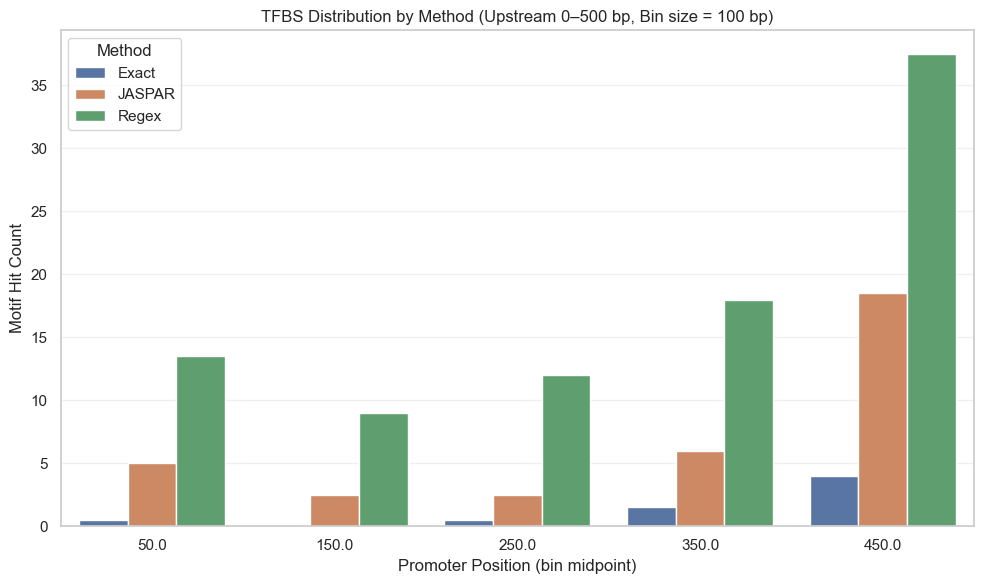

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

# === load datasets ===
def load_and_label(path, method, regulation):
    df = pd.read_csv(path)
    df["Method"] = method
    df["Regulation"] = regulation
    return df

df_pos_exact  = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_exact.csv",  "Exact",  "Positive")
df_pos_regex  = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_regex.csv",  "Regex",  "Positive")
df_pos_jaspar = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv", "JASPAR", "Positive")

df_neg_exact  = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_exact.csv",  "Exact",  "Negative")
df_neg_regex  = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_regex.csv",  "Regex",  "Negative")
df_neg_jaspar = load_and_label("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/neg_jaspar.csv", "JASPAR", "Negative")

# === combine ===
df = pd.concat([df_pos_exact, df_neg_exact, df_pos_regex, df_neg_regex, df_pos_jaspar, df_neg_jaspar], ignore_index=True)

# ensure numeric start
df["Start"] = pd.to_numeric(df["Start"], errors="coerce")
df = df.dropna(subset=["Start"])

# binning: 0–500 bp, 5 bins of 100 bp
bin_edges = np.linspace(0, 500, 6)
df["bin"] = pd.cut(df["Start"], bins=bin_edges)
df["Mid"] = df["bin"].apply(lambda x: x.mid if pd.notna(x) else np.nan)

# count per bin
binned = df.groupby(["Method", "Regulation", "Mid"]).size().reset_index(name="Count")

# === histogram / bar chart ===
plt.figure(figsize=(10, 6))
sns.barplot(
    data=binned,
    x="Mid", y="Count",
    hue="Method",
    ci=None
)

plt.title("TFBS Distribution by Method (Upstream 0–500 bp, Bin size = 100 bp)")
plt.xlabel("Promoter Position (bin midpoint)")


plt.ylabel("Motif Hit Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load your JASPAR profile match CSV
df = pd.read_csv("/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/scripts/pos_jaspar.csv")

# Ensure Start is numeric
df["Start"] = pd.to_numeric(df["Start"], errors="coerce")

# Filter for Start < 500 (only genomic sequences, optional)
df_filtered = df[(df["Start"] < 500) & (df["Sequence_Type"] == "Genomic")]
df_filtered = df_filtered.dropna(subset=["Start"])  # Drop rows with NaN in Start
df_filtered
# Save or display
print(len(df_filtered))


53


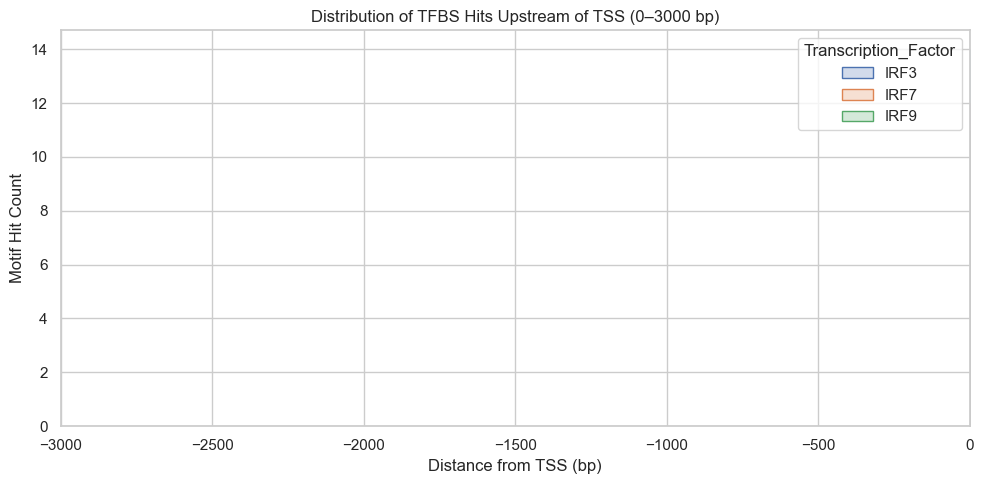

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load the data
match_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/pos_jaspar.csv')
seq_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/human_IFN_up_regulation_extract.csv')

upstream_len = seq_df['Upstream'].str.len().max()
gene_len = seq_df['Gene_seq'].str.len().max()
downstream_len = seq_df['Downstream'].str.len().max()
# Extract only genomic sequences
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']
# Ensure Start is numeric
match_df["Start"] = pd.to_numeric(match_df["Start"], errors="coerce")
match_df = match_df.dropna(subset=["Start"])  # Drop rows with NaN in Start

# Calculate promoter positions
# Promoter position is defined as the start position minus the upstream length
match_df['Promoter_Position'] = match_df['Start'] - upstream_len

# Keep only upstream hits
upstream_df = match_df[match_df['Promoter_Position'] < 0].copy()

# Convert to positive distance from TSS (0 = TSS, 3000 = farthest upstream)
upstream_df["Upstream_Pos"] = -upstream_df["Promoter_Position"]

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(
    data=upstream_df,
    x="Upstream_Pos",
    hue="Transcription_Factor",
    bins=30,            # 100 bp bins for 3000 bp region
    element="step",
    stat="count",
    common_norm=False
)

plt.ylabel("Motif Hit Count")
plt.xlabel("Distance from TSS (bp)")
plt.title("Distribution of TFBS Hits Upstream of TSS (0–3000 bp)")
plt.xlim(-3000, 0)
plt.tight_layout()
plt.savefig('tfbs_upstream_distribution.svg', format='svg', bbox_inches='tight')
plt.show()



### Histogram plot for Upstream Region

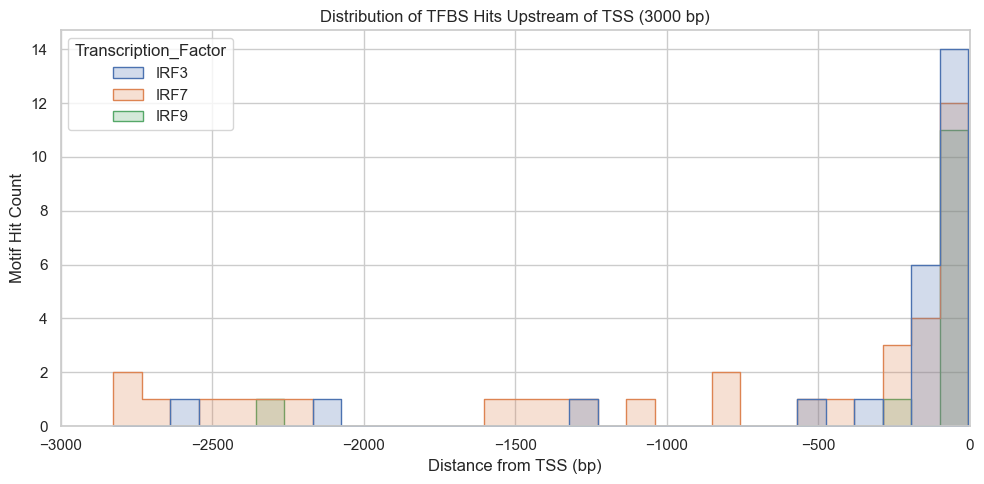

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load data
match_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/pos_jaspar.csv')
seq_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/human_IFN_up_regulation_extract.csv')

# Fixed lengths
upstream_len = 3000  

# Filter genomic sequences
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']

# Ensure numeric Start
match_df["Start"] = pd.to_numeric(match_df["Start"], errors="coerce")
match_df = match_df.dropna(subset=["Start"])

# Calculate distance from TSS (negative for upstream)
match_df["Rel_start"] = match_df["Start"] - upstream_len

# Keep only upstream hits
upstream_df = match_df[match_df["Rel_start"] < 0].copy()

# Plot histogram (bins of 100 bp)
plt.figure(figsize=(10, 5))
sns.histplot(
    data=upstream_df,
    x="Rel_start",
    hue="Transcription_Factor",
    bins=30,
    element="step",
    stat="count",
    common_norm=False
)

plt.ylabel("Motif Hit Count")
plt.xlabel("Distance from TSS (bp)")
plt.title("Distribution of TFBS Hits Upstream of TSS (3000 bp)")
plt.xlim(-3000, 0)
plt.tight_layout()
plt.savefig('tfbs_upstream_distribution.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()  # Close the plot to free memory

        Species Gene_Name          Gene_ID Transcription_Factor Strand  Start  \
0  Homo sapiens       MX1  ENSG00000157601                 IRF3      +   3543   
1  Homo sapiens       MX1  ENSG00000157601                 IRF3      +   3549   
2  Homo sapiens       MX1  ENSG00000157601                 IRF7      +   3548   
3  Homo sapiens       MX1  ENSG00000157601                 IRF7      +  28520   
4  Homo sapiens       MX1  ENSG00000157601                 IRF7      -  11236   

     End Sequence_Type  
0   3560       Genomic  
1   3566       Genomic  
2   3561       Genomic  
3  28533       Genomic  
4  11249       Genomic  
Empty DataFrame
Columns: [Species, Gene_Name, Gene_ID, Transcription_Factor, Strand, Start, End, Sequence_Type]
Index: []


TypeError: 'NoneType' object is not iterable

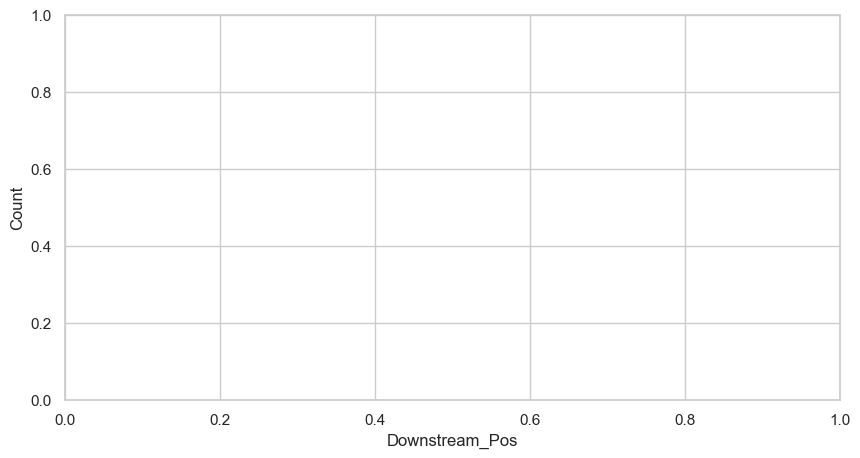

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load data
match_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/pos_jaspar.csv')
seq_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/human_IFN_up_regulation_extract.csv')

# Fixed lengths
upstream_len = 3000  # Get max upstream length from seq_df
gene_len = seq_df['Gene_seq'].str.len().max()      # Get max gene length from seq_df This is the problem. Which I get the max length of the gene sequence
downstream_len = 3000

# Filter genomic sequences
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']
# Ensure numeric Start
match_df["Start"] = pd.to_numeric(match_df["Start"], errors="coerce")
match_df = match_df.dropna(subset=["Start"])  # Drop rows with NaN in Start

print(match_df.head())

# Define absolute start/end positions of downstream region
downstream_start = upstream_len + gene_len
downstream_end = upstream_len + gene_len + 3000

# Keep only downstream hits
downstream_df = match_df[
    (match_df["Start"] >= downstream_start)
].copy()

print(downstream_df.head())




# Plot histogram (bins of 100 bp)
plt.figure(figsize=(10, 5))
sns.histplot(
    data=downstream_df,
    x="Downstream_Pos",
    hue="Transcription_Factor",
    bins=30,
    element="step",
    stat="count",
    common_norm=False
)

plt.ylabel("Motif Hit Count")
plt.xlabel("Distance from Gene End (bp)")
plt.title("Distribution of TFBS Hits Downstream of Gene (3000 bp)")
plt.xlim(0, 3000)
plt.tight_layout()
plt.show()


## Downstream Region

Found 21 downstream hits
          Species Gene_Name          Gene_ID Transcription_Factor Strand  \
11   Homo sapiens      GBP4  ENSG00000162654                 IRF7      +   
71   Homo sapiens      GBP7  ENSG00000213512                 IRF7      -   
201  Homo sapiens      TAP1  ENSG00000168394                 IRF3      -   
205  Homo sapiens      TAP1  ENSG00000168394                 IRF7      -   
209  Homo sapiens    TRIM14  ENSG00000106785                 IRF7      +   

     Start    End Sequence_Type  Gene_Len  Downstream_Start  Downstream_End  \
11   20981  20994       Genomic     17799             20799           23799   
71   50004  50017       Genomic     44268             47268           50268   
201  12764  12781       Genomic      8608             11608           14608   
205  12763  12776       Genomic      8608             11608           14608   
209  54496  54509       Genomic     49948             52948           55948   

     Downstream_Pos  
11              182  

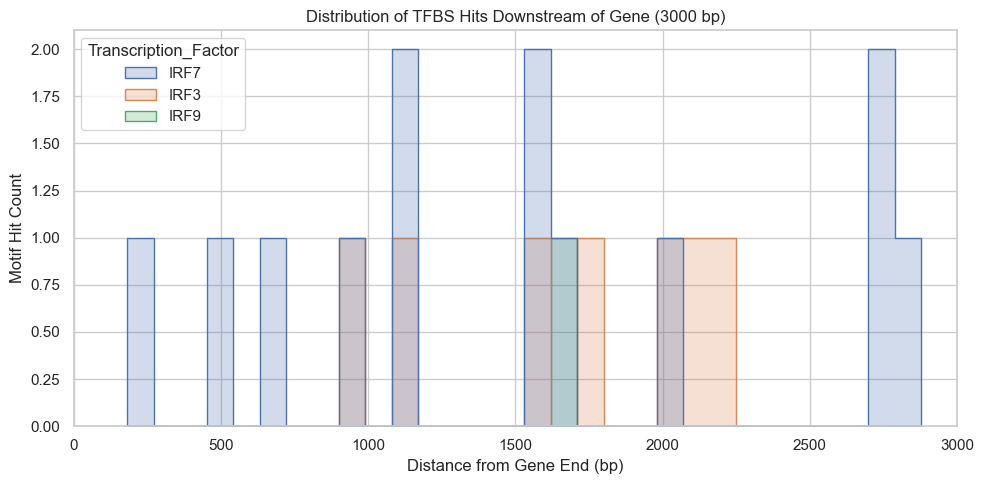

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load data
match_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/pos_jaspar.csv')
seq_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/human_IFN_up_regulation_extract.csv')

# Fixed lengths
upstream_len = 3000
downstream_len = 3000

# Filter genomic sequences
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']

# Ensure numeric Start
match_df["Start"] = pd.to_numeric(match_df["Start"], errors="coerce")
match_df = match_df.dropna(subset=["Start"])

# Map gene lengths from seq_df to match_df
# Make sure the key column names match exactly between the two DataFrames
gene_len_map = dict(zip(seq_df['gene_name'], seq_df['Gene_seq'].str.len()))
match_df['Gene_Len'] = match_df['Gene_Name'].map(gene_len_map)

# Drop rows with missing gene lengths (in case of mismatched names)
match_df = match_df.dropna(subset=['Gene_Len'])

# Calculate per-gene downstream start/end
match_df['Downstream_Start'] = upstream_len + match_df['Gene_Len']
match_df['Downstream_End'] = match_df['Downstream_Start'] + downstream_len

# Keep only downstream hits per gene
downstream_df = match_df[
    (match_df['Start'] >= match_df['Downstream_Start']) &
    (match_df['Start'] <= match_df['Downstream_End'])
].copy()

# Distance from gene end
downstream_df['Downstream_Pos'] = downstream_df['Start'] - downstream_df['Downstream_Start']

print(f"Found {len(downstream_df)} downstream hits")
print(downstream_df.head())

# Plot histogram (bins of 100 bp)
plt.figure(figsize=(10, 5))
sns.histplot(
    data=downstream_df,
    x="Downstream_Pos",
    hue="Transcription_Factor",
    bins=30,
    element="step",
    stat="count",
    common_norm=False
)

plt.ylabel("Motif Hit Count")
plt.xlabel("Distance from Gene End (bp)")
plt.title("Distribution of TFBS Hits Downstream of Gene (3000 bp)")
plt.xlim(0, 3000)
plt.tight_layout()
plt.savefig('tfbs_downstream_distribution.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()

## Histogram plot Gene body (Normalised)

Found 448 gene body hits
        Species Gene_Name          Gene_ID Transcription_Factor Strand  Start  \
0  Homo sapiens       MX1  ENSG00000157601                 IRF3      +   3543   
1  Homo sapiens       MX1  ENSG00000157601                 IRF3      +   3549   
2  Homo sapiens       MX1  ENSG00000157601                 IRF7      +   3548   
3  Homo sapiens       MX1  ENSG00000157601                 IRF7      +  28520   
4  Homo sapiens       MX1  ENSG00000157601                 IRF7      -  11236   

     End Sequence_Type  Gene_Len  Gene_Start  Gene_End  Gene_Pos_Normalized  \
0   3560       Genomic     50052        3000     53052             0.010849   
1   3566       Genomic     50052        3000     53052             0.010969   
2   3561       Genomic     50052        3000     53052             0.010949   
3  28533       Genomic     50052        3000     53052             0.509870   
4  11249       Genomic     50052        3000     53052             0.164549   

   Gene_Pos_P

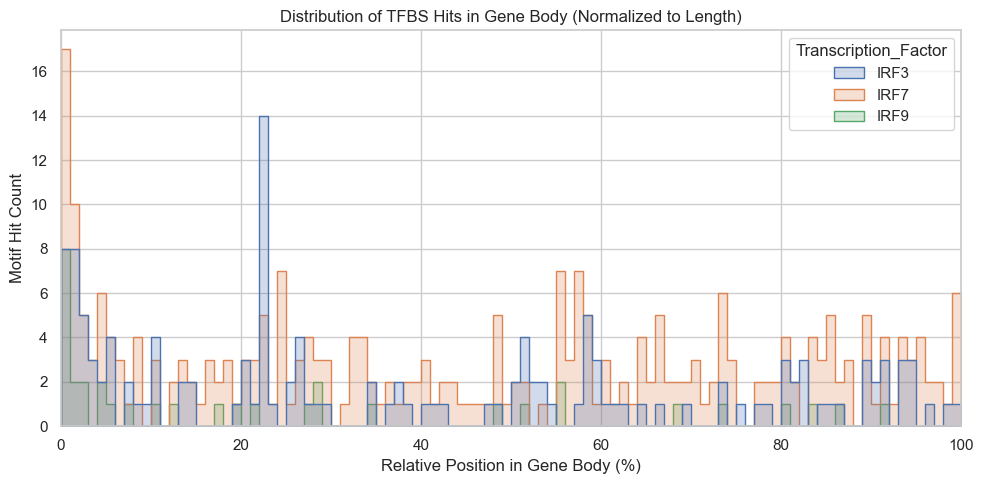

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Load data
match_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/pos_jaspar.csv')
seq_df = pd.read_csv('/Users/sang/bioinformatics_msc_project_2025/TFBS-explorer-19/outputs/human_IFN_up_regulation_extract.csv')

# Fixed lengths
upstream_len = 3000

# Filter genomic sequences
match_df = match_df[match_df['Sequence_Type'] == 'Genomic']

# Ensure numeric Start
match_df["Start"] = pd.to_numeric(match_df["Start"], errors="coerce")
match_df = match_df.dropna(subset=["Start"])

# Map gene lengths
gene_len_map = dict(zip(seq_df['gene_name'], seq_df['Gene_seq'].str.len()))
match_df['Gene_Len'] = match_df['Gene_Name'].map(gene_len_map)
match_df = match_df.dropna(subset=['Gene_Len'])

# Calculate gene body start/end per gene
match_df['Gene_Start'] = upstream_len
match_df['Gene_End'] = match_df['Gene_Start'] + match_df['Gene_Len']

# Filter only hits within gene body
gene_body_df = match_df[
    (match_df['Start'] >= match_df['Gene_Start']) &
    (match_df['Start'] <= match_df['Gene_End'])
].copy()

# Normalize to 0–1 scale along gene body
gene_body_df['Gene_Pos_Normalized'] = (gene_body_df['Start'] - gene_body_df['Gene_Start']) / gene_body_df['Gene_Len']

# Optional: convert to percentage bins (0–100%)
gene_body_df['Gene_Pos_Percent'] = (gene_body_df['Gene_Pos_Normalized'] * 100)

print(f"Found {len(gene_body_df)} gene body hits")
print(gene_body_df.head())

# Plot histogram (100 bins)
plt.figure(figsize=(10, 5))
sns.histplot(
    data=gene_body_df,
    x="Gene_Pos_Percent",
    hue="Transcription_Factor",
    bins=100,
    element="step",
    stat="count",
    common_norm=False
)

plt.ylabel("Motif Hit Count")
plt.xlabel("Relative Position in Gene Body (%)")
plt.title("Distribution of TFBS Hits in Gene Body (Normalized to Length)")
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig('tfbs_gene_body_distribution.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()  # Close the plot to free memory